# Regression in Python

***
This is a very quick run-through of some basic statistical concepts, adapted from [Lab 4 in Harvard's CS109](https://github.com/cs109/2015lab4) course. Please feel free to try the original lab if you're feeling ambitious :-) The CS109 git repository also has the solutions if you're stuck.

* Linear Regression Models
* Prediction using linear regression

Linear regression is used to model and predict continuous outcomes with normal random errors. There are nearly an infinite number of different types of regression models and each regression model is typically defined by the distribution of the prediction errors (called "residuals") of the type of data. Logistic regression is used to model binary outcomes whereas Poisson regression is used to predict counts. In this exercise, we'll see some examples of linear regression as well as Train-test splits.

The packages we'll cover are: `statsmodels`, `seaborn`, and `scikit-learn`. While we don't explicitly teach `statsmodels` and `seaborn` in the Springboard workshop, those are great libraries to know.
***

<img width=600 height=300 src="https://imgs.xkcd.com/comics/sustainable.png"/>
***

In [1]:
# special IPython command to prepare the notebook for matplotlib and other libraries
%matplotlib inline 

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.outliers_influence import OLSInfluence
import sklearn
from sklearn import metrics
import seaborn as sns

# special matplotlib argument for improved plots
from matplotlib import rcParams
sns.set_style("whitegrid")
sns.set_context("poster")


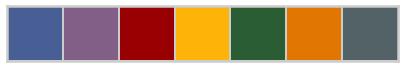

In [2]:
# set color palette
colors = ["dusky blue", "dusty purple", "blood red", "amber", "pine", "pumpkin", "gunmetal"]
colors_palette = sns.xkcd_palette(colors)
sns.palplot(sns.xkcd_palette(colors))
sns.set_palette(colors_palette)
rgb = sns.xkcd_rgb

***
# Part 1: Introduction to Linear Regression
### Purpose of linear regression
***
<div class="span5 alert alert-info">

<p> Given a dataset containing predictor variables $X$ and outcome/response variable $Y$, linear regression can be used to: </p>
<ul>
  <li> Build a <b>predictive model</b> to predict future values of $\hat{Y}$, using new data $X^*$ where $Y$ is unknown.</li>
  <li> Model the <b>strength of the relationship</b> between each independent variable $X_i$ and $Y$</li>
    <ul>
      <li> Many times, only a subset of independent variables $X_i$ will have a linear relationship with $Y$</li>
      <li> Need to figure out which $X_i$ contributes most information to predict $Y$ </li>
    </ul>
   <li>It is in many cases, the first pass prediction algorithm for continuous outcomes. </li>
</ul>
</div>

### A Brief Mathematical Recap
***

[Linear Regression](http://en.wikipedia.org/wiki/Linear_regression) is a method to model the relationship between a set of independent variables $X$ (also knowns as explanatory variables, features, predictors) and a dependent variable $Y$.  This method assumes the relationship between each predictor $X$ is **linearly** related to the dependent variable $Y$. The most basic linear regression model contains one independent variable $X$, we'll call this the simple model. 

$$ Y = \beta_0 + \beta_1 X + \epsilon$$

where $\epsilon$ is considered as an unobservable random variable that adds noise to the linear relationship. In linear regression, $\epsilon$ is assumed to be normally distributed with a mean of 0. In other words, what this means is that on average, if we know $Y$, a roughly equal number of predictions $\hat{Y}$ will be above $Y$ and others will be below $Y$. That is, on average, the error is zero. The residuals, $\epsilon$ are also assumed to be "i.i.d.": independently and identically distributed. Independence means that the residuals are not correlated -- the residual from one prediction has no effect on the residual from another prediction. Correlated errors are common in time series analysis and spatial analyses.

* $\beta_0$ is the intercept of the linear model and represents the average of $Y$ when all independent variables $X$ are set to 0.

* $\beta_1$ is the slope of the line associated with the regression model and represents the average effect of a one-unit increase in $X$ on $Y$.

* Back to the simple model. The model in linear regression is the *conditional mean* of $Y$ given the values in $X$ is expressed a linear function.  

$$ y = f(x) = E(Y | X = x)$$ 

![conditional mean](images/conditionalmean.png)
*Image from http://www.learner.org/courses/againstallodds/about/glossary.html. Note this image uses $\alpha$ and $\beta$ instead of $\beta_0$ and $\beta_1$.*

* The goal is to estimate the coefficients (e.g. $\beta_0$ and $\beta_1$). We represent the estimates of the coefficients with a "hat" on top of the letter.  

$$ \hat{\beta}_0, \hat{\beta}_1 $$

* Once we estimate the coefficients $\hat{\beta}_0$ and $\hat{\beta}_1$, we can use these to predict new values of $Y$ given new data $X$.

$$\hat{y} = \hat{\beta}_0 + \hat{\beta}_1 x_1$$

* Multiple linear regression is when you have more than one independent variable and the estimation involves matrices
    * $X_1$, $X_2$, $X_3$, $\ldots$


* How do you estimate the coefficients? 
    * There are many ways to fit a linear regression model
    * The method called **least squares** is the most common methods
    * We will discuss least squares

$$ Y = \beta_0 + \beta_1 X_1 + \ldots + \beta_p X_p + \epsilon$$ 
    
### Estimating $\hat\beta$: Least squares
***
[Least squares](http://en.wikipedia.org/wiki/Least_squares) is a method that can estimate the coefficients of a linear model by minimizing the squared residuals: 

$$ \mathscr{L} = \sum_{i=1}^N \epsilon_i^2 = \sum_{i=1}^N \left( y_i - \hat{y}_i \right)^2  = \sum_{i=1}^N \left(y_i - \left(\beta_0 + \beta_1 x_i\right)\right)^2 $$

where $N$ is the number of observations and $\epsilon$ represents a residual or error, ACTUAL - PREDICTED.  

#### Estimating the intercept $\hat{\beta_0}$ for the simple linear model

We want to minimize the squared residuals and solve for $\hat{\beta_0}$ so we take the partial derivative of $\mathscr{L}$ with respect to $\hat{\beta_0}$ 

$
\begin{align}
\frac{\partial \mathscr{L}}{\partial \hat{\beta_0}} &= \frac{\partial}{\partial \hat{\beta_0}} \sum_{i=1}^N \epsilon^2 \\
&= \frac{\partial}{\partial \hat{\beta_0}} \sum_{i=1}^N \left( y_i - \hat{y}_i \right)^2 \\
&= \frac{\partial}{\partial \hat{\beta_0}} \sum_{i=1}^N \left( y_i - \left( \hat{\beta}_0 + \hat{\beta}_1 x_i \right) \right)^2 \\
&= -2 \sum_{i=1}^N \left( y_i - \left( \hat{\beta}_0 + \hat{\beta}_1 x_i \right) \right) \hspace{25mm} \mbox{(by chain rule)} \\
&= -2 \sum_{i=1}^N (y_i - \hat{\beta}_0 - \hat{\beta}_1 x_i) \\
&= -2 \left[ \left( \sum_{i=1}^N y_i \right) - N \hat{\beta_0} - \hat{\beta}_1 \left( \sum_{i=1}^N x_i
\right) \right] \\
& 2 \left[ N \hat{\beta}_0 + \hat{\beta}_1 \sum_{i=1}^N x_i - \sum_{i=1}^N y_i \right] = 0 \hspace{20mm} \mbox{(Set equal to 0 and solve for $\hat{\beta}_0$)} \\
& N \hat{\beta}_0 + \hat{\beta}_1 \sum_{i=1}^N x_i - \sum_{i=1}^N y_i = 0 \\
& N \hat{\beta}_0 = \sum_{i=1}^N y_i - \hat{\beta}_1 \sum_{i=1}^N x_i \\
& \hat{\beta}_0 = \frac{\sum_{i=1}^N y_i - \hat{\beta}_1 \sum_{i=1}^N x_i}{N} \\
& \hat{\beta}_0 = \frac{\sum_{i=1}^N y_i}{N} - \hat{\beta}_1 \frac{\sum_{i=1}^N x_i}{N} \\
& \boxed{\hat{\beta}_0 = \bar{y} - \hat{\beta}_1 \bar{x}}
\end{align}
$

Using this new information, we can compute the estimate for $\hat{\beta}_1$ by taking the partial derivative of $\mathscr{L}$ with respect to $\hat{\beta}_1$.

$
\begin{align}
\frac{\partial \mathscr{L}}{\partial \hat{\beta_1}} &= \frac{\partial}{\partial \hat{\beta_1}} \sum_{i=1}^N \epsilon^2 \\
&= \frac{\partial}{\partial \hat{\beta_1}} \sum_{i=1}^N \left( y_i - \hat{y}_i \right)^2 \\
&= \frac{\partial}{\partial \hat{\beta_1}} \sum_{i=1}^N \left( y_i - \left( \hat{\beta}_0 + \hat{\beta}_1 x_i \right) \right)^2 \\
&= 2 \sum_{i=1}^N \left( y_i - \left( \hat{\beta}_0 + \hat{\beta}_1 x_i \right) \right) \left( -x_i \right) \hspace{25mm}\mbox{(by chain rule)} \\
&= -2 \sum_{i=1}^N x_i \left( y_i - \hat{\beta}_0 - \hat{\beta}_1 x_i \right) \\
&= -2 \sum_{i=1}^N x_i (y_i - \hat{\beta}_0 x_i - \hat{\beta}_1 x_i^2) \\
&= -2 \sum_{i=1}^N x_i (y_i - \left( \bar{y} - \hat{\beta}_1 \bar{x} \right) x_i - \hat{\beta}_1 x_i^2) \\
&= -2 \sum_{i=1}^N (x_i y_i - \bar{y}x_i + \hat{\beta}_1\bar{x}x_i - \hat{\beta}_1 x_i^2) \\
&= -2 \left[ \sum_{i=1}^N x_i y_i - \bar{y} \sum_{i=1}^N x_i + \hat{\beta}_1\bar{x}\sum_{i=1}^N x_i - \hat{\beta}_1 \sum_{i=1}^N x_i^2 \right] \\
&= -2 \left[ \hat{\beta}_1 \left\{ \bar{x} \sum_{i=1}^N x_i - \sum_{i=1}^N x_i^2 \right\} + \left\{ \sum_{i=1}^N x_i y_i - \bar{y} \sum_{i=1}^N x_i \right\}\right] \\
& 2 \left[ \hat{\beta}_1 \left\{ \sum_{i=1}^N x_i^2 - \bar{x} \sum_{i=1}^N x_i \right\} + \left\{ \bar{y} \sum_{i=1}^N x_i - \sum_{i=1}^N x_i y_i \right\} \right] = 0 \\
& \hat{\beta}_1 = \frac{-\left( \bar{y} \sum_{i=1}^N x_i - \sum_{i=1}^N x_i y_i \right)}{\sum_{i=1}^N x_i^2 - \bar{x}\sum_{i=1}^N x_i} \\
&= \frac{\sum_{i=1}^N x_i y_i - \bar{y} \sum_{i=1}^N x_i}{\sum_{i=1}^N x_i^2 - \bar{x} \sum_{i=1}^N x_i} \\
& \boxed{\hat{\beta}_1 = \frac{\sum_{i=1}^N x_i y_i - \bar{x}\bar{y}n}{\sum_{i=1}^N x_i^2 - n \bar{x}^2}}
\end{align}
$

The solution can be written in compact matrix notation as

$$\hat\beta =  (X^T X)^{-1}X^T Y$$ 

We wanted to show you this in case you remember linear algebra, in order for this solution to exist we need $X^T X$ to be invertible. Of course this requires a few extra assumptions, $X$ must be full rank so that $X^T X$ is invertible, etc. Basically, $X^T X$ is full rank if all rows and columns are linearly independent. This has a loose relationship to variables and observations being independent respective. **This is important for us because this means that having redundant features in our regression models will lead to poorly fitting (and unstable) models.** We'll see an implementation of this in the extra linear regression example.

***
# Part 2: Exploratory Data Analysis for Linear Relationships

The [Boston Housing data set](https://archive.ics.uci.edu/ml/datasets/Housing) contains information about the housing values in suburbs of Boston.  This dataset was originally taken from the StatLib library which is maintained at Carnegie Mellon University and is now available on the UCI Machine Learning Repository. 


## Load the Boston Housing data set from `sklearn`
***

This data set is available in the [sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html#sklearn.datasets.load_boston) python module which is how we will access it today.  

In [3]:
from sklearn.datasets import load_boston
import pandas as pd

boston = load_boston()

In [4]:
boston.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])

In [5]:
boston.data.shape

(506, 13)

In [6]:
# Print column names
print(boston.feature_names)

['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']


In [7]:
# Print description of Boston housing data set
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

Now let's explore the data set itself. 

In [8]:
bos = pd.DataFrame(boston.data)
bos.head()

0     1     2    3      4      5     6       7    8      9    10  \
0  0.00632  18.0  2.31  0.0  0.538  6.575  65.2  4.0900  1.0  296.0  15.3   
1  0.02731   0.0  7.07  0.0  0.469  6.421  78.9  4.9671  2.0  242.0  17.8   
2  0.02729   0.0  7.07  0.0  0.469  7.185  61.1  4.9671  2.0  242.0  17.8   
3  0.03237   0.0  2.18  0.0  0.458  6.998  45.8  6.0622  3.0  222.0  18.7   
4  0.06905   0.0  2.18  0.0  0.458  7.147  54.2  6.0622  3.0  222.0  18.7   

       11    12  
0  396.90  4.98  
1  396.90  9.14  
2  392.83  4.03  
3  394.63  2.94  
4  396.90  5.33

There are no column names in the DataFrame. Let's add those. 

In [9]:
bos.columns = boston.feature_names
bos.head()

CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   PTRATIO       B  LSTAT  
0     15.3  396.90   4.98  
1     17.8  396.90   9.14  
2     17.8  392.83   4.03  
3     18.7  394.63   2.94  
4     18.7  396.90   5.33

Now we have a pandas DataFrame called `bos` containing all the data we want to use to predict Boston Housing prices.  Let's create a variable called `PRICE` which will contain the prices. This information is contained in the `target` data. 

In [10]:
print(boston.target.shape)

(506,)


In [11]:
bos['PRICE'] = boston.target
bos.head()

CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   PTRATIO       B  LSTAT  PRICE  
0     15.3  396.90   4.98   24.0  
1     17.8  396.90   9.14   21.6  
2     17.8  392.83   4.03   34.7  
3     18.7  394.63   2.94   33.4  
4     18.7  396.90   5.33   36.2

## EDA and Summary Statistics
***

Let's explore this data set.  First we use `describe()` to get basic summary statistics for each of the columns. 

In [12]:
bos.describe()

CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.613524   11.363636   11.136779    0.069170    0.554695    6.284634   
std      8.601545   23.322453    6.860353    0.253994    0.115878    0.702617   
min      0.006320    0.000000    0.460000    0.000000    0.385000    3.561000   
25%      0.082045    0.000000    5.190000    0.000000    0.449000    5.885500   
50%      0.256510    0.000000    9.690000    0.000000    0.538000    6.208500   
75%      3.677083   12.500000   18.100000    0.000000    0.624000    6.623500   
max     88.976200  100.000000   27.740000    1.000000    0.871000    8.780000   

              AGE         DIS         RAD         TAX     PTRATIO           B  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean    68.574901    3.795043    9.549407  408.237154   18.455534  356.674032   
std     28.148861    2.105710    8.707259  168.537116    2.164946   91.294864   
min      2.900000    1.129600    1.000000  187.000000   12.600000    0.320000   
25%     45.025000    2.100175    4.000000  279.000000   17.400000  375.377500   
50%     77.500000    3.207450    5.000000  330.000000   19.050000  391.440000   
75%     94.075000    5.188425   24.000000  666.000000   20.200000  396.225000   
max    100.000000   12.126500   24.000000  711.000000   22.000000  396.900000   

            LSTAT       PRICE  
count  506.000000  506.000000  
mean    12.653063   22.532806  
std      7.141062    9.197104  
min      1.730000    5.000000  
25%      6.950000   17.025000  
50%     11.360000   21.200000  
75%     16.955000   25.000000  
max     37.970000   50.000000

### Scatterplots
***

Let's look at some scatter plots for three variables: 'CRIM' (per capita crime rate), 'RM' (number of rooms) and 'PTRATIO' (pupil-to-teacher ratio in schools).  

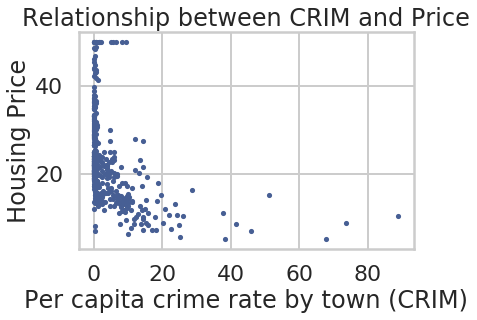

In [13]:
plt.scatter(bos.CRIM, bos.PRICE, s=10)
plt.xlabel("Per capita crime rate by town (CRIM)")
plt.ylabel("Housing Price")
plt.title("Relationship between CRIM and Price");

<div class="span5 alert alert-info">
<h3>Part 2 Checkup Exercise Set I</h3>

<p><b>Exercise:</b> What kind of relationship do you see? e.g. positive, negative?  linear? non-linear? Is there anything else strange or interesting about the data? What about outliers?</p>


<p><b>Exercise:</b> Create scatter plots between *RM* and *PRICE*, and *PTRATIO* and *PRICE*. Label your axes appropriately using human readable labels. Tell a story about what you see.</p>

<p><b>Exercise:</b> What are some other numeric variables of interest? Why do you think they are interesting? Plot scatterplots with these variables and *PRICE* (house price) and tell a story about what you see.</p>

</div>

In [14]:
# your turn: describe relationship


There are many areas with crime rates near zero. I believe the data is not scaled appropriately to see these small values.<br>
Omitting these, the correlation is negative, with all areas of high crime rate being in the lower housing price areas.<br>
We do have a few outliers with high crime in areas with low housing prices, as well as some in the very high housing prices.<br>
It would be interesting to have this data broken down into crime types to see trends between the two regions of outliers.<br>
Also, after a bit of research, I found the reason why many plots have odd ceilings across their tops.<br>
It's because the Census Service censored the data by restricting the range of housing prices to $50,000.

In [15]:
# remove the top quarter of the crime range
low_crime = bos[bos['CRIM'] < bos['CRIM'].quantile(0.75)]
len(low_crime['CRIM'])

379

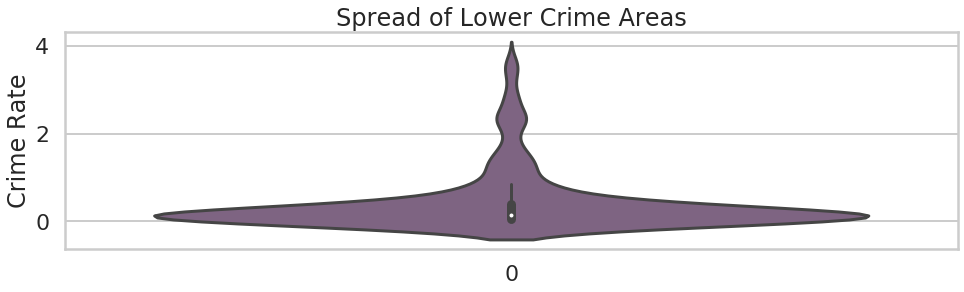

In [16]:
# plot crime rate without top quarter of values
figsize(16, 4)

sns.violinplot(data=low_crime['CRIM'], color=rgb[colors[1]])
plt.ylabel('Crime Rate')

plt.title('Spread of Lower Crime Areas');

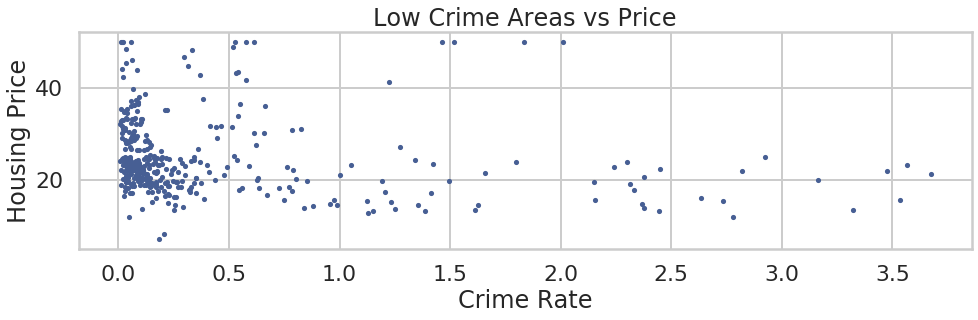

In [17]:
# plot low crime rate vs housing price
figsize(16, 4)

plt.scatter(low_crime['CRIM'], low_crime['PRICE'], s=10)

plt.xlabel('Crime Rate')
plt.ylabel('Housing Price')

plt.title('Low Crime Areas vs Price');

In this range, the correlation does not appear to be linear.

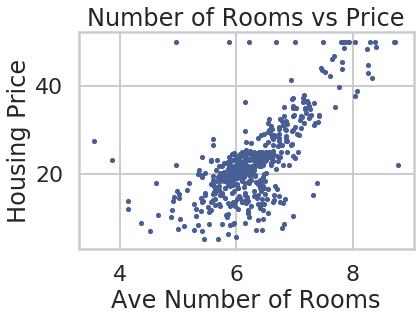

In [18]:
# your turn: scatter plot between *RM* and *PRICE*
figsize(6, 4)

plt.scatter(bos.RM, bos.PRICE, s=10)

plt.xlabel('Ave Number of Rooms')
plt.ylabel('Housing Price')

plt.title('Number of Rooms vs Price');

The price is positively correlated to the number of rooms, which makes sense.

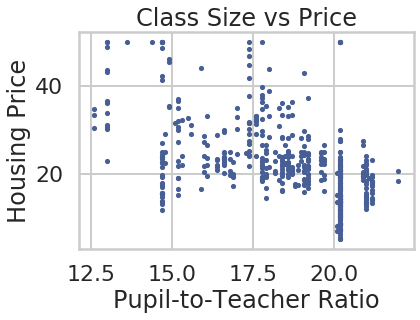

In [19]:
# your turn: scatter plot between *PTRATIO* and *PRICE*
figsize(6, 4)

plt.scatter(bos.PTRATIO, bos.PRICE, s=10)

plt.xlabel('Pupil-to-Teacher Ratio')
plt.ylabel('Housing Price')

plt.title('Class Size vs Price');

The correlation between the housing price and the pupil-to-teacher ratio is slightly negative.

In [20]:
# your turn: create some other scatter plots


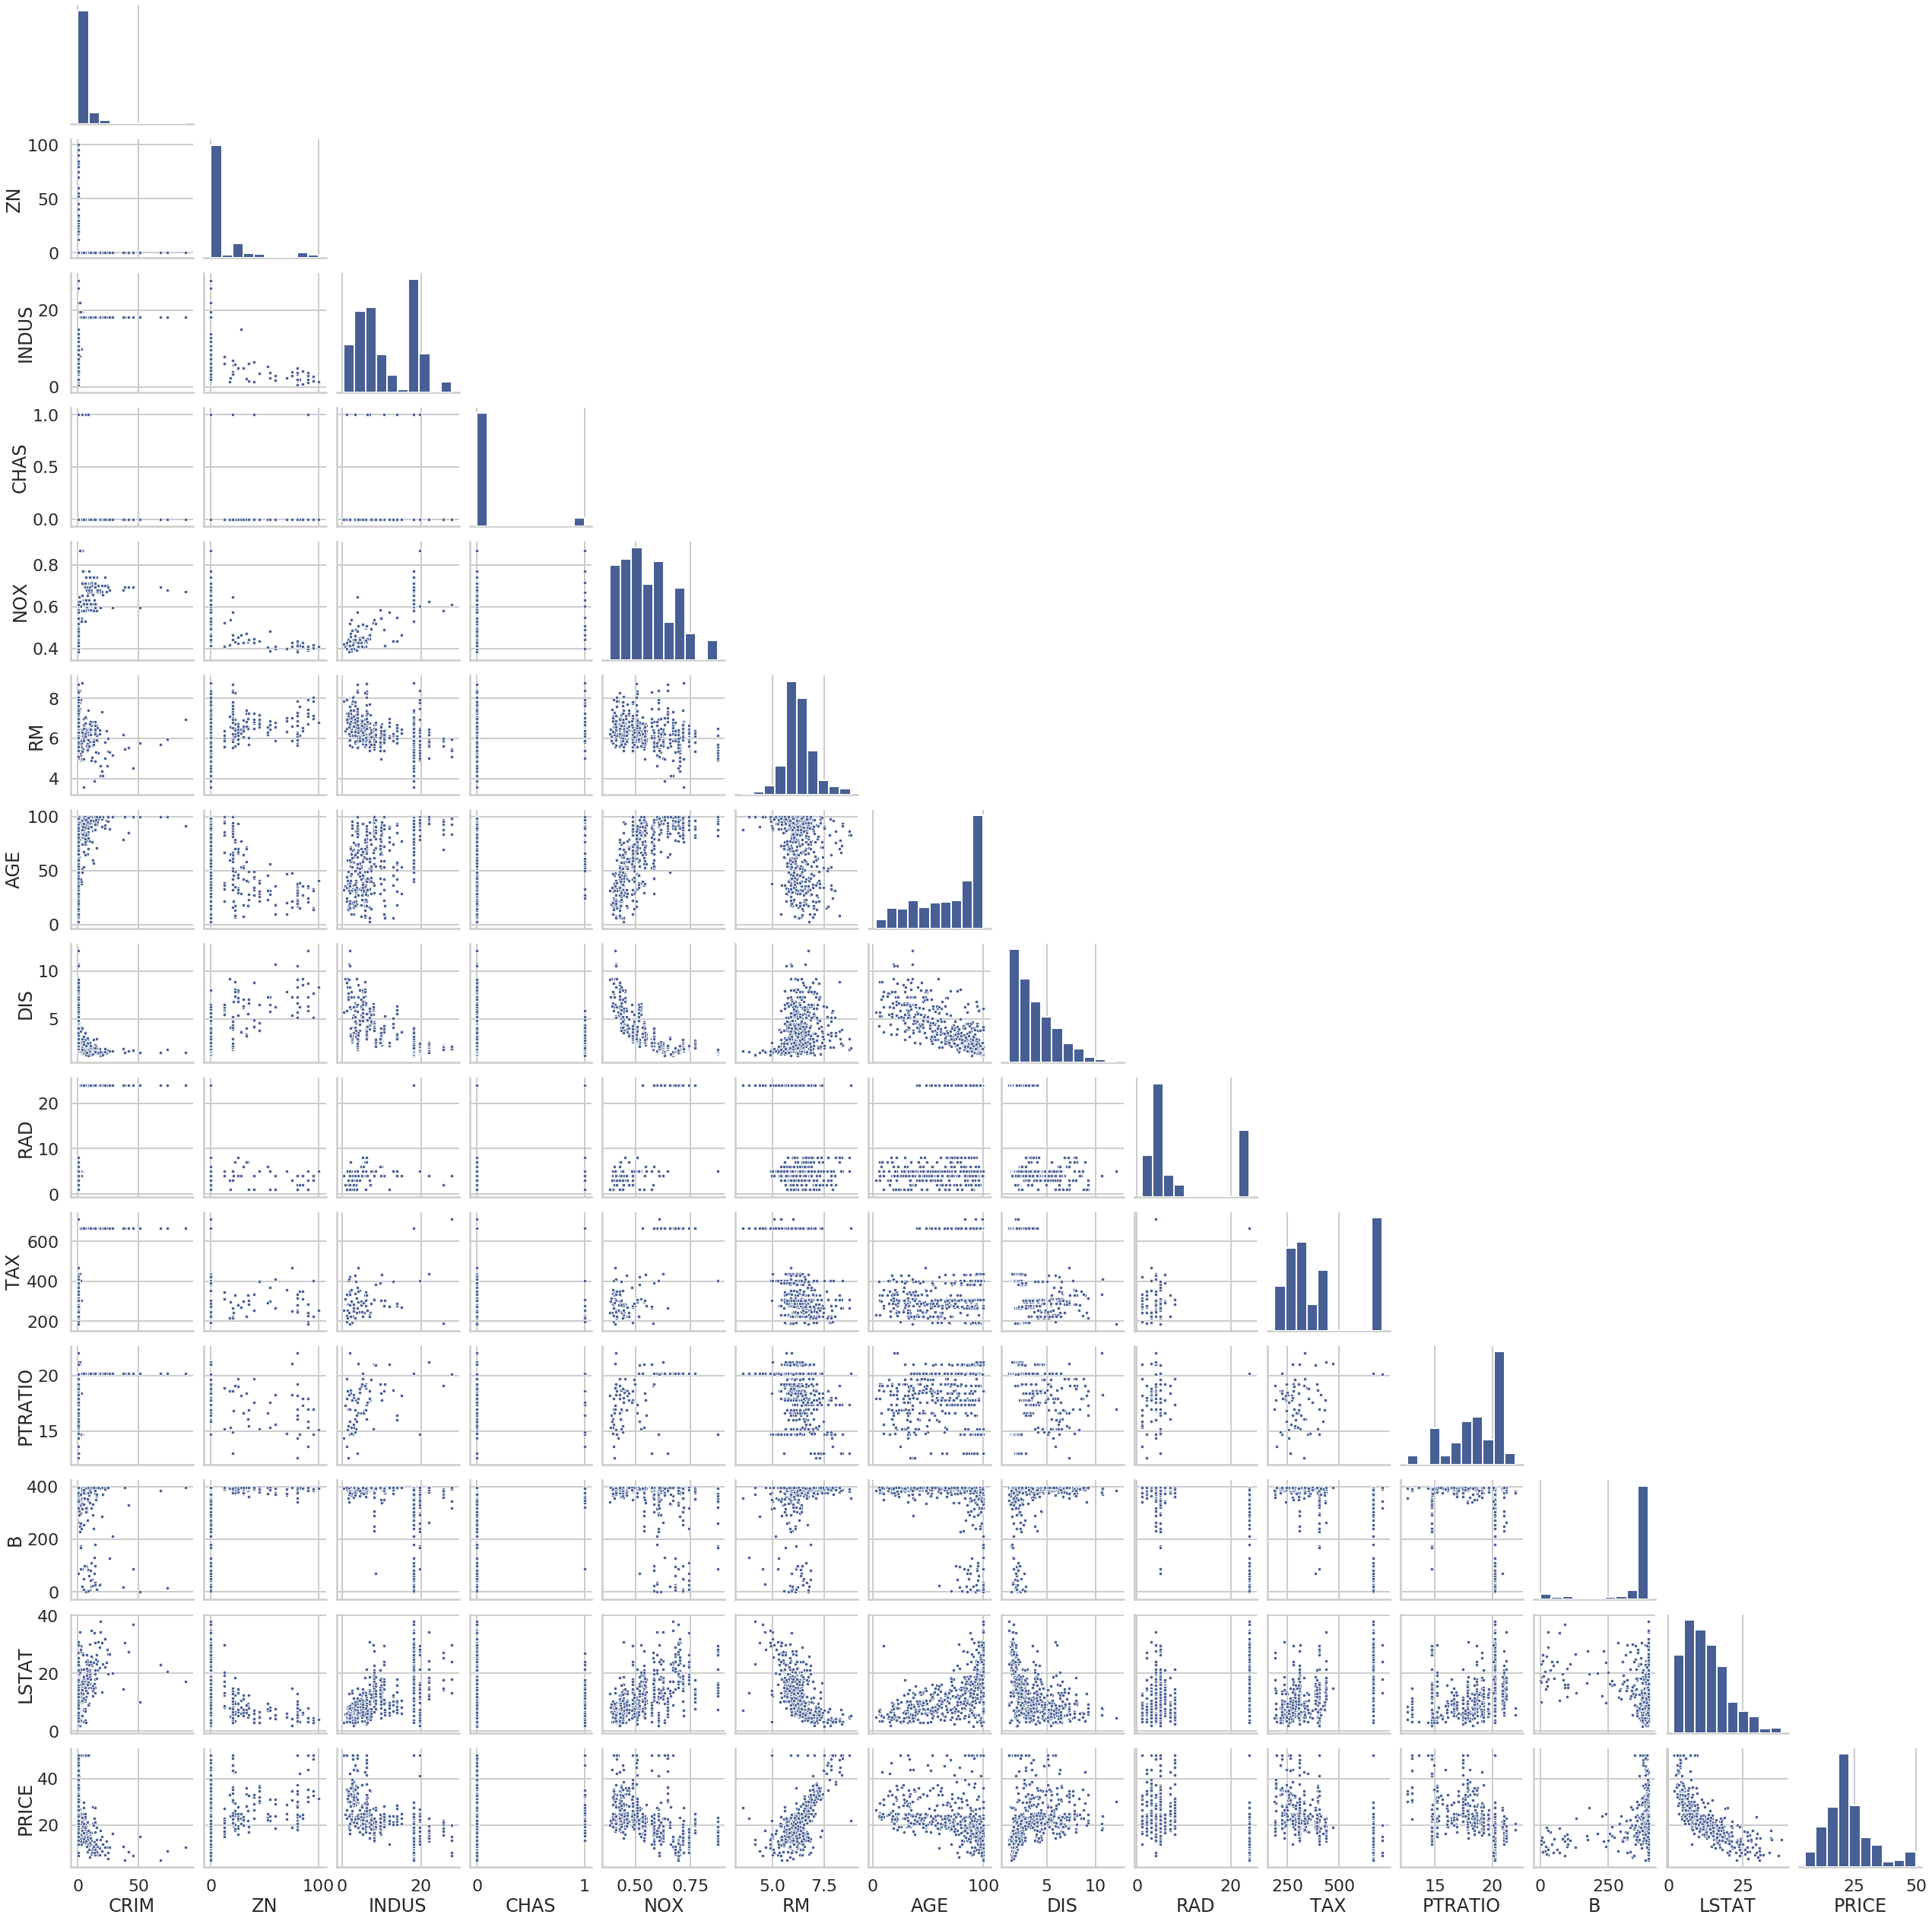

In [21]:
# look at all scatterplots to find correlations
sns.pairplot(bos, plot_kws={"s": 20}, corner=True);

Not suprisingly, the price is negatively correlated to poverty.

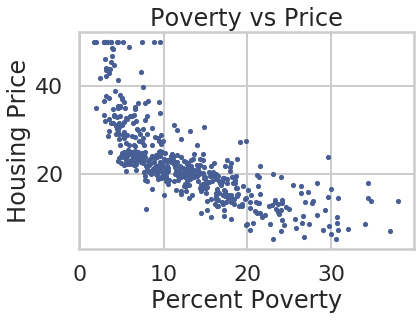

In [22]:
# plot poverty vs housing price
figsize(6, 4)

plt.scatter(bos.LSTAT, bos.PRICE, s=10)

plt.xlabel('Percent Poverty')
plt.ylabel('Housing Price')

plt.title('Poverty vs Price');

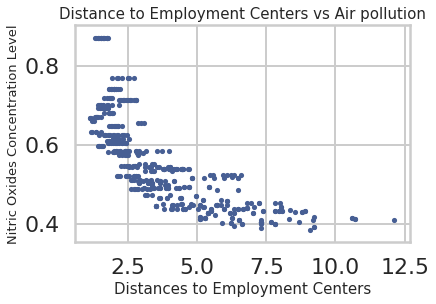

In [23]:
# plot distance to employment centers vs air polution
figsize(6, 4)

plt.scatter(bos.DIS, bos.NOX, s=10)

plt.xlabel('Distances to Employment Centers', fontdict={'fontsize': 15})
plt.ylabel('Nitric Oxides Concentration Level', fontdict={'fontsize': 13})

plt.title('Distance to Employment Centers vs Air pollution', fontdict={'fontsize': 15});

The air is more polluted near employment centers. Let's check on the house prices there.

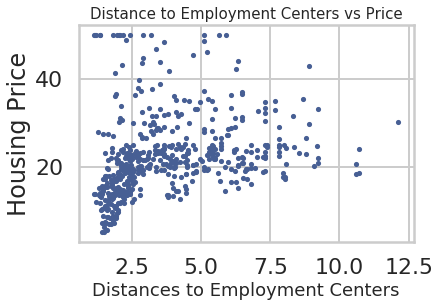

In [24]:
# plot distance to employment centers vs housing price
figsize(6, 4)

plt.scatter(bos.DIS, bos.PRICE, s=10)

plt.xlabel('Distances to Employment Centers', fontdict={'fontsize': 18})
plt.ylabel('Housing Price')

plt.title('Distance to Employment Centers vs Price', fontdict={'fontsize': 15});

There is a positive correlation between distance from employment centers and the housing prices.

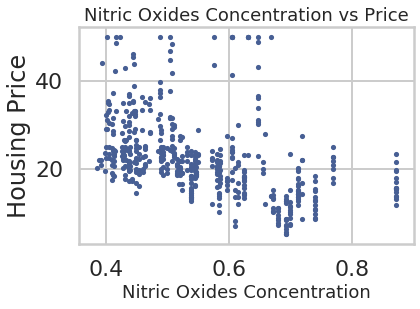

In [25]:
# plot air pollution vs housing price
figsize(6, 4)

plt.scatter(bos.NOX, bos.PRICE, s=10)

plt.xlabel('Nitric Oxides Concentration', fontdict={'fontsize': 18})
plt.ylabel('Housing Price')

plt.title('Nitric Oxides Concentration vs Price', fontdict={'fontsize': 18});

There is a negative correlation between air polution and housing prices.

### Scatterplots using Seaborn
***

[Seaborn](https://stanford.edu/~mwaskom/software/seaborn/) is a cool Python plotting library built on top of matplotlib. It provides convenient syntax and shortcuts for many common types of plots, along with better-looking defaults.

We can also use [seaborn regplot](https://stanford.edu/~mwaskom/software/seaborn/tutorial/regression.html#functions-to-draw-linear-regression-models) for the scatterplot above. This provides automatic linear regression fits (useful for data exploration later on). Here's one example below.

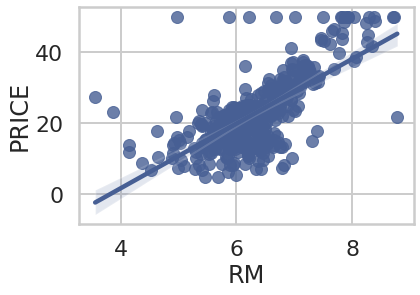

In [26]:
sns.regplot(y="PRICE", x="RM", data=bos, fit_reg = True);

### Histograms
***


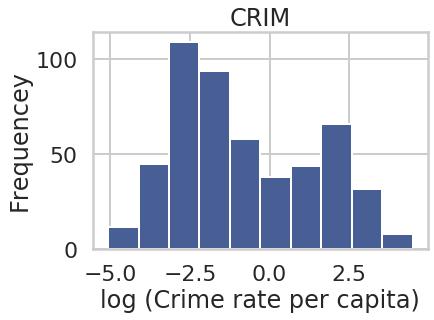

In [27]:
plt.hist(np.log(bos.CRIM))
plt.title("CRIM")
plt.xlabel("log (Crime rate per capita)")
plt.ylabel("Frequencey")
plt.show()

<div class="span5 alert alert-info">
<h3>Part 2 Checkup Exercise Set II</h3>

<p><b>Exercise:</b> In the above histogram, we took the logarithm of the crime rate per capita. Repeat this histogram without taking the log. What was the purpose of taking the log? What do we gain by making this transformation? What do you now notice about this variable that is not obvious without making the transformation?

<p><b>Exercise:</b> Plot the histogram for *RM* and *PTRATIO* against each other, along with the two variables you picked in the previous section. We are looking for correlations in predictors here.</p>
</div>

In [28]:
#your turn


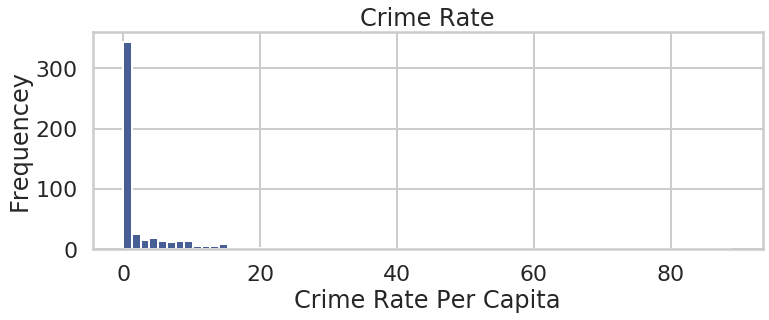

In [29]:
# plot histogram of crime rate
figsize(12, 4)

plt.hist(bos.CRIM, bins=70)

plt.title('Crime Rate')
plt.xlabel('Crime Rate Per Capita')

plt.ylabel('Frequencey');

The log transform of the data allows for better inspection of data points that are dense at small values, especially if there are high value outliers.<br>
The cost is losing any intuitive meaning in the values of the x variable, since crime rates are not negative.<br>
When viewed with the log transformation, this variable appears bimodal.

In [30]:
# remove the top half of the crime range
lowest_crime = bos[bos['CRIM'] < bos['CRIM'].quantile(0.5)]
len(lowest_crime['CRIM'])

253

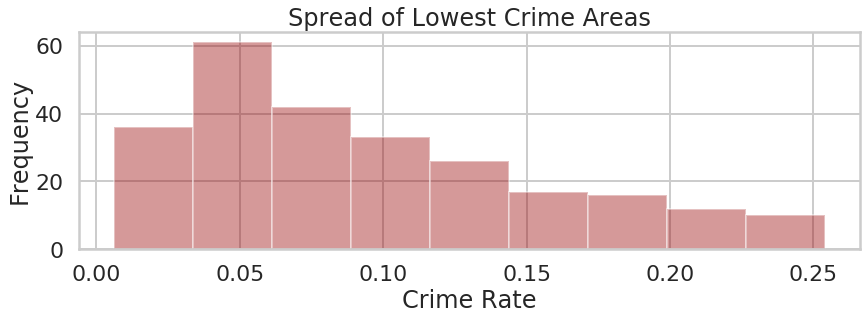

In [31]:
# plot crime rate without top half of values
figsize(14, 4)

sns.distplot(lowest_crime['CRIM'], kde=False, axlabel='Crime Rate', color=rgb[colors[2]])

plt.ylabel('Frequency')

plt.title('Spread of Lowest Crime Areas');

Here, we can see the lowest crime rate areas with higher granularity, while still perserving the scale of the data.

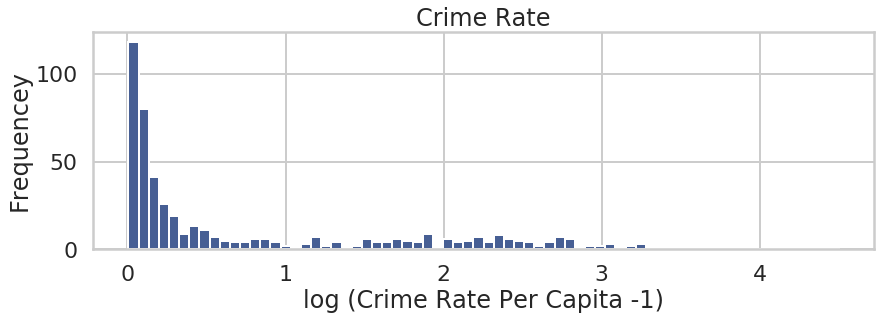

In [32]:
# plot histogram of crime rate
figsize(14,4)

plt.hist(np.log(bos.CRIM + 1), bins=70)

plt.title('Crime Rate')
plt.xlabel('log (Crime Rate Per Capita -1)')

plt.ylabel('Frequencey');

Finally, if the log transfromed data is shifted before the transformation is applied, the values stay positive.<br>
Of course, this is purely for aesthetical purposes, since the values are still not intuitive with respect to actual crimes per capita.

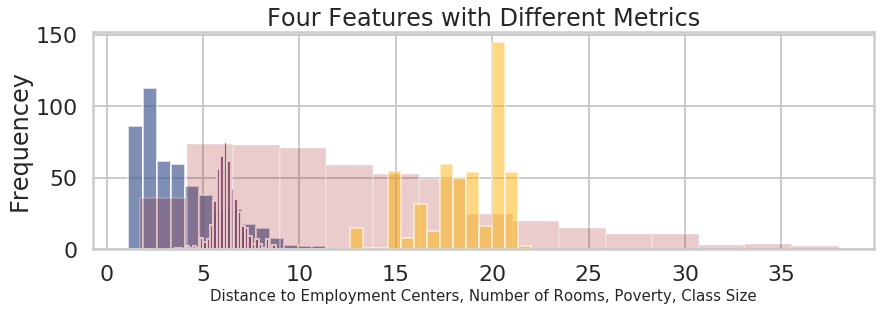

In [33]:
# plot histograms "against each other"
figsize(14,4)

sns.distplot(bos['DIS'], kde=False, hist_kws = {'alpha': 0.7})
sns.distplot(bos['RM'], kde=False, hist_kws = {'alpha': 0.9})
sns.distplot(bos['LSTAT'], kde=False, hist_kws = {'alpha': 0.2})
sns.distplot(bos['PTRATIO'], kde=False, hist_kws = {'alpha': 0.5})

plt.xlabel('Distance to Employment Centers, Number of Rooms, Poverty, Class Size', fontdict={'fontsize': 15})
plt.ylabel('Frequencey')

plt.title('Four Features with Different Metrics');

I don't think the mess in that plot can show any useful correlations.<br>
I'll assume the instructions meant to plot them next to each other.

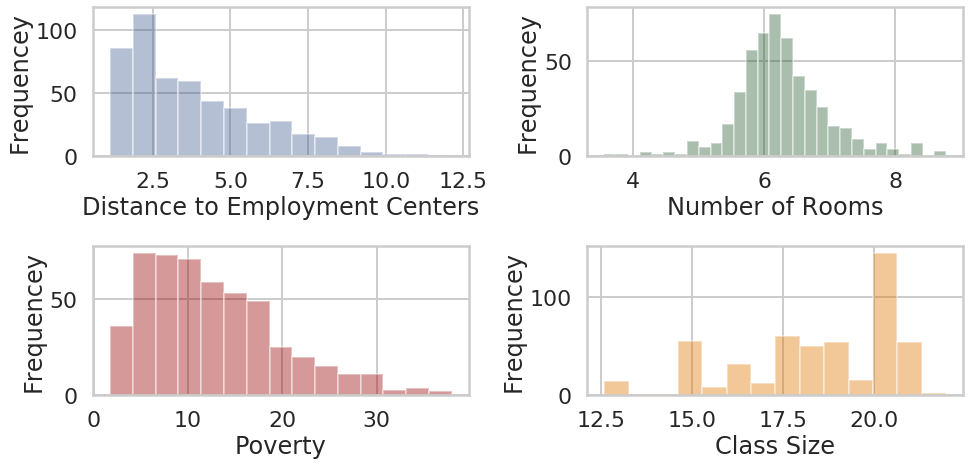

In [34]:
# plot histograms "next to each other"

fig, ax = plt.subplots(2, 2, figsize=(14, 7))

plt.subplot(2,2,1)
sns.distplot(bos['DIS'], kde=False, color=rgb[colors[0]])

plt.xlabel('Distance to Employment Centers')
plt.ylabel('Frequencey')

plt.subplot(2,2,2)
sns.distplot(bos['RM'], kde=False, color=rgb[colors[4]])

plt.xlabel('Number of Rooms')
plt.ylabel('Frequencey')

plt.subplot(2,2,3)
sns.distplot(bos['LSTAT'], kde=False, color=rgb[colors[2]])

plt.xlabel('Poverty')
plt.ylabel('Frequencey')

plt.subplot(2,2,4)
sns.distplot(bos['PTRATIO'], kde=False, color=rgb[colors[5]])

plt.xlabel('Class Size')
plt.ylabel('Frequencey')

plt.tight_layout();

Looking at histograms to find correlations is not fruitful data exploration.<br>
Plotting data with different scales side by side doesn't seem like the best way to go about looking for correlations between the features.<br>
Let's look the scatterplots, again.

In [35]:
hist_lst = ['RM', 'PTRATIO', 'LSTAT', 'DIS']

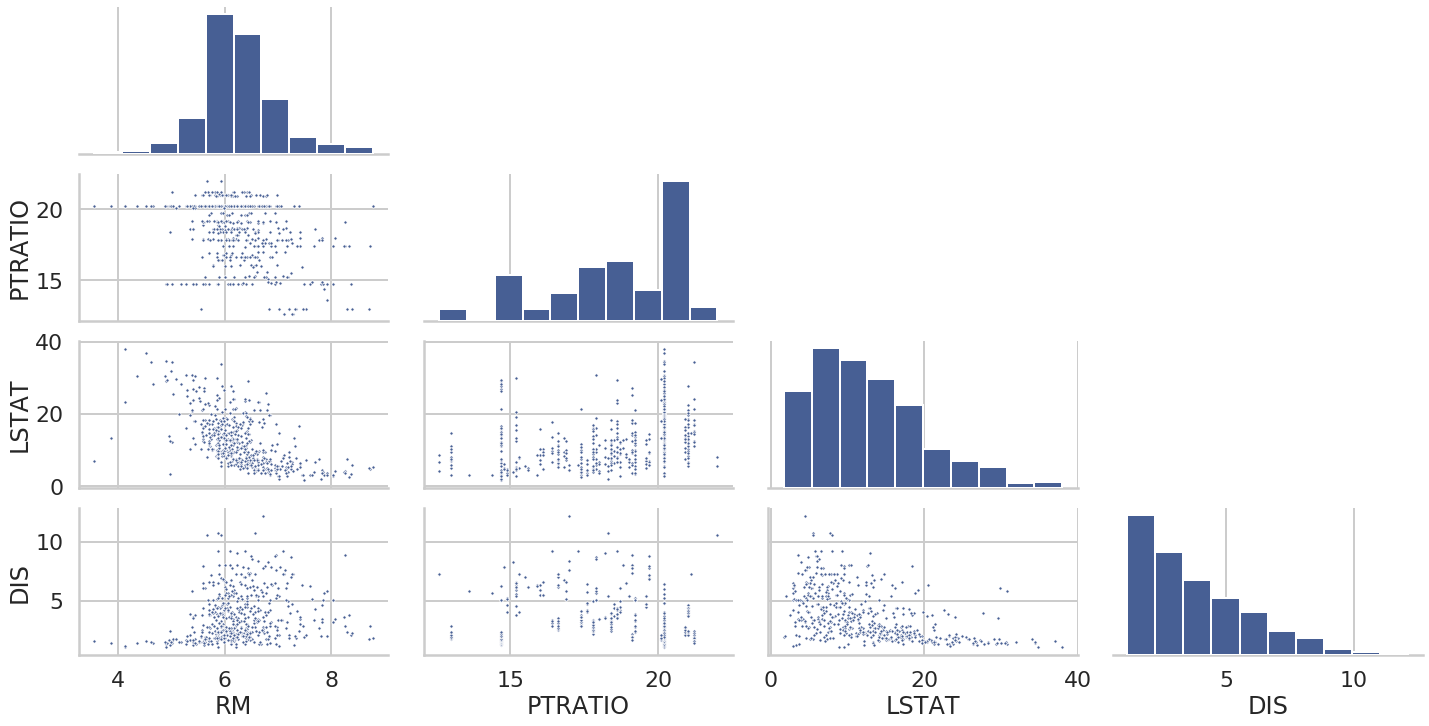

In [36]:
# look for correlation with scatterplots
figsize(10, 3)
sns.pairplot(bos[hist_lst], plot_kws={'s': 10}, aspect=2, corner=True);

It would appear that there is a negative correlation between poverty and number of rooms.<br>
There is a negative correlation between poverty and distance from employment centers, as well.

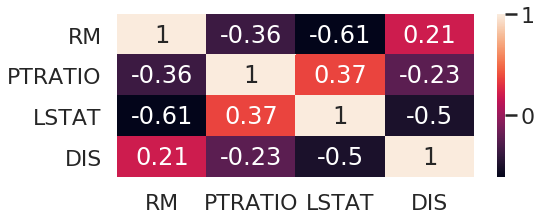

In [37]:
# use seaborn for correlations
figsize(8, 3)
sns.heatmap(bos[hist_lst].corr(),annot=True)

Yes, the correlations seen in the scatterplots are confirmed by plotting the results of using the correlation method.<br>
Also, there is a slight positive correlation between poverty and class size and a slight negative correlation between class size and number of rooms.

## Part 3: Linear Regression with Boston Housing Data Example
***

Here, 

$Y$ = boston housing prices (called "target" data in python, and referred to as the dependent variable or response variable)

and

$X$ = all the other features (or independent variables, predictors or explanatory variables)

which we will use to fit a linear regression model and predict Boston housing prices. We will use the least-squares method to estimate the coefficients.  

We'll use two ways of fitting a linear regression. We recommend the first but the second is also powerful in its features.

### Fitting Linear Regression using `statsmodels`
***
[Statsmodels](http://statsmodels.sourceforge.net/) is a great Python library for a lot of basic and inferential statistics. It also provides basic regression functions using an R-like syntax, so it's commonly used by statisticians. While we don't cover statsmodels officially in the Data Science Intensive workshop, it's a good library to have in your toolbox. Here's a quick example of what you could do with it. The version of least-squares we will use in statsmodels is called *ordinary least-squares (OLS)*. There are many other versions of least-squares such as [partial least squares (PLS)](https://en.wikipedia.org/wiki/Partial_least_squares_regression) and [weighted least squares (WLS)](https://en.wikipedia.org/wiki/Iteratively_reweighted_least_squares).

In [38]:
# Import regression modules
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [39]:
# statsmodels works nicely with pandas dataframes
# The thing inside the "quotes" is called a formula, a bit on that below
m = ols('PRICE ~ RM',bos).fit()
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     471.8
Date:                Tue, 12 May 2020   Prob (F-statistic):           2.49e-74
Time:                        23:47:50   Log-Likelihood:                -1673.1
No. Observations:                 506   AIC:                             3350.
Df Residuals:                     504   BIC:                             3359.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -34.6706      2.650    -13.084      0.0

#### Interpreting coefficients

There is a ton of information in this output. But we'll concentrate on the coefficient table (middle table). We can interpret the `RM` coefficient (9.1021) by first noticing that the p-value (under `P>|t|`) is so small, basically zero. This means that the number of rooms, `RM`, is a statisticall significant predictor of `PRICE`. The regression coefficient for `RM` of 9.1021 means that *on average, each additional room is associated with an increase of $\$9,100$ in house price net of the other variables*. The confidence interval gives us a range of plausible values for this average change, about ($\$8,279, \$9,925$), definitely not chump change. 

In general, the $\hat{\beta_i}, i > 0$ can be interpreted as the following: "A one unit increase in $x_i$ is associated with, on average, a $\hat{\beta_i}$ increase/decrease in $y$ net of all other variables."

On the other hand, the interpretation for the intercept, $\hat{\beta}_0$ is the average of $y$ given that all of the independent variables $x_i$ are 0.

####  `statsmodels` formulas
***
This formula notation will seem familiar to `R` users, but will take some getting used to for people coming from other languages or are new to statistics.

The formula gives instruction for a general structure for a regression call. For `statsmodels` (`ols` or `logit`) calls you need to have a Pandas dataframe with column names that you will add to your formula. In the below example you need a pandas data frame that includes the columns named (`Outcome`, `X1`,`X2`, ...), but you don't need to build a new dataframe for every regression. Use the same dataframe with all these things in it. The structure is very simple:

`Outcome ~ X1`

But of course we want to to be able to handle more complex models, for example multiple regression is doone like this:

`Outcome ~ X1 + X2 + X3`

In general, a formula for an OLS multiple linear regression is

`Y ~ X1 + X2 + ... + Xp`

This is the very basic structure but it should be enough to get you through the homework. Things can get much more complex. You can force statsmodels to treat variables as categorical with the `C()` function, call numpy functions to transform data such as `np.log` for extremely-skewed data, or fit a model without an intercept by including `- 1` in the formula. For a quick run-down of further uses see the `statsmodels` [help page](http://statsmodels.sourceforge.net/devel/example_formulas.html).


Let's see how our model actually fit our data. We can see below that there is a ceiling effect, we should probably look into that. Also, for large values of $Y$ we get underpredictions, most predictions are below the 45-degree gridlines. 

<div class="span5 alert alert-info">
<h3>Part 3 Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a scatterplot between the predicted prices, available in `m.fittedvalues` (where `m` is the fitted model) and the original prices. How does the plot look? Do you notice anything interesting or weird in the plot? Comment on what you see.</p>
</div>

In [40]:
# your turn

In [41]:
# look at some predicted housing prices
m.fittedvalues[:5]

0    25.175746
1    23.774021
2    30.728032
3    29.025938
4    30.382152
dtype: float64

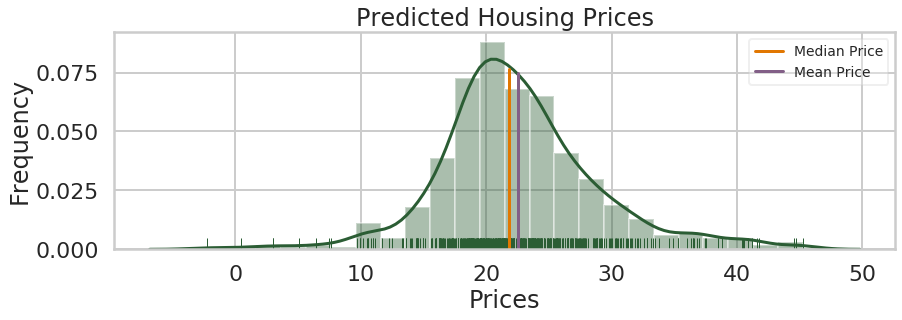

In [42]:
# plot predicted prices
figsize(14, 4)

sns.distplot(m.fittedvalues, bins=24, rug=True, axlabel='Prices', color=rgb[colors[4]])
plt.axvline(np.median(m.fittedvalues), ymin=0, ymax=0.83, label='Median Price', color=rgb[colors[5]])
plt.axvline(np.mean(m.fittedvalues), ymin=0, ymax=0.81, label='Mean Price', color=rgb[colors[1]])

plt.ylabel('Frequency')

plt.legend(loc=1, fontsize='xx-small', framealpha=0.3)
plt.title('Predicted Housing Prices');

The distribution of the predicted prices has heavy tails due to the outliers at both extremes.

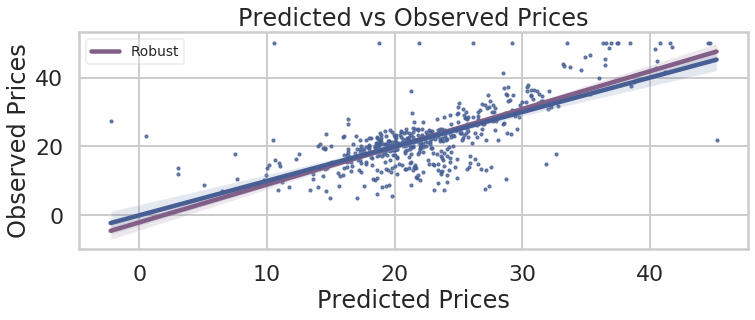

In [43]:
# plot scatterplot with regression line
figsize(12, 4)
# plot regression line weighing against outliers
sns.regplot(x=m.fittedvalues, y=bos.PRICE, scatter_kws={'s':10}, fit_reg = True, 
            color=rgb[colors[1]], label='Robust', robust=True, scatter=False)
# plot normal regression line
sns.regplot(x=m.fittedvalues, y=bos.PRICE, scatter_kws={'s':10}, fit_reg = True)

plt.xlabel('Predicted Prices')
plt.ylabel('Observed Prices')

plt.legend(loc=2, markerscale=2, fontsize='xx-small', framealpha=0.3)
plt.title('Predicted vs Observed Prices');

The plot shows a positive correlation between the observed and predicted housing prices<br>
Aside from the aforementioned price ceiling, there are a few additional outliers.<br>
There is one data point that has a negative value.<br>
From a visual inspection, the outliers are affecting the regression.

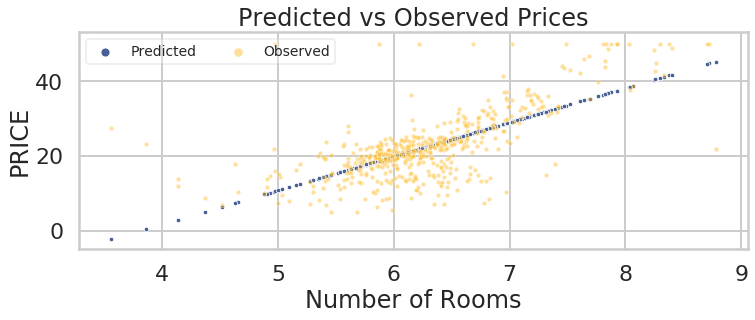

In [44]:
# plot scatterplot
figsize(12, 4)

sns.scatterplot(x=bos.RM, y=m.fittedvalues, s=20, label='Predicted')
sns.scatterplot(x=bos.RM, y=bos.PRICE, s=20, alpha= 0.4, color=rgb[colors[3]], label='Observed')

plt.xlabel('Number of Rooms')

plt.title('Predicted vs Observed Prices')
plt.legend(loc=2, ncol=2, markerscale=2, fontsize='xx-small', framealpha=0.3);

Looking at the values plotted against each other, it can be seen that the predicted values are tightly grouped.<br>
Using the number of rooms as the sole predictor of housing prices does not capture all of the observed variability.<br>
This model is overfit and may perform poorly as a predictor on any new data.

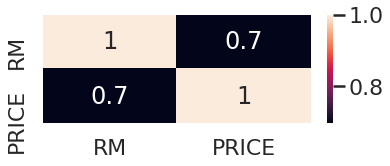

In [45]:
# use seaborn for correlations
figsize(6, 2)
sns.heatmap(bos[['RM', 'PRICE']].corr(),annot=True);

There's a fairly strong correlation here, resulting in low variance in the predicted values.

### Fitting Linear Regression using `sklearn`


In [46]:
from sklearn.linear_model import LinearRegression
X = bos.drop('PRICE', axis = 1)

# This creates a LinearRegression object
lm = LinearRegression()
lm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

#### What can you do with a LinearRegression object? 
***
Check out the scikit-learn [docs here](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html). We have listed the main functions here. Most machine learning models in scikit-learn follow this same API of fitting a model with `fit`, making predictions with `predict` and the appropriate scoring function `score` for each model.

Main functions | Description
--- | --- 
`lm.fit()` | Fit a linear model
`lm.predit()` | Predict Y using the linear model with estimated coefficients
`lm.score()` | Returns the coefficient of determination (R^2). *A measure of how well observed outcomes are replicated by the model, as the proportion of total variation of outcomes explained by the model*

#### What output can you get?

In [47]:
# Look inside lm object
# lm.<tab>

Here is a chart of what you can get from a LinearRegression object.

Parameter|Default|Options|Result
-|-|-|-|
copy_X|True|if False|X may be overwritten
fit_intercept|True|if False|no intercept used in calculation (data is expected to be centered)
n_jobs|None|if int > 1|number of processors to use
normalize|False|if True|predictors will be normalized before regression

Method|Functionality
-|-|
fit|fit linear model
get_params|get parameters for this estimator
predict|predict using linear model
score|return coefficients of determination R^2 of prediction
set_params|set parameters for this estimate

Output | Description
--- | --- 
`lm.coef_` | Estimated coefficients
`lm.intercept_` | Estimated intercept 

### Fit a linear model
***

The `lm.fit()` function estimates the coefficients the linear regression using least squares. 

In [48]:
# Use all 13 predictors to fit linear regression model
lm.fit(X, bos.PRICE)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

<div class="span5 alert alert-info">
<h3>Part 3 Checkup Exercise Set II</h3>

<p><b>Exercise:</b> How would you change the model to not fit an intercept term? Would you recommend not having an intercept? Why or why not? For more information on why to include or exclude an intercept, look [here](https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faq-what-is-regression-through-the-origin/).</p>

<p><b>Exercise:</b> One of the assumptions of the linear model is that the residuals must be i.i.d. (independently and identically distributed). To satisfy this, is it enough that the residuals are normally distributed? Explain your answer.</p>

<p><b>Exercise:</b> True or false. To use linear regression, $Y$ must be normally distributed. Explain your answer.</p>
</div>


In [49]:
# your turn


To not fit an intercept term, set the parameter fit_intercept=False, when creating the LinearRegression object.<br>
It may be necessary to have the regression line pass through the origin (intercept is zero) to express an obvious starting value when looking at correlations.<br>
I would not recommend putting the intercept through the origin for our model. There are assumed to be no houses with zero rooms.

No, it is not necessary for the residuals to be normally distributed.<br>
If residuals are i.i.d, they must be independent and have the same probability distribution with constant variances<br>
That distribution does not need to be a normal distribution, though.<br>
One example would be independently drawing datum from the same uniform distribution.<br>
They would be independent and have the same distribution, but that distribution would not be normal.<br>
However, they should be normal for the purposes of an OLS regression, if confidence or prediction intervals are to be calculated.

False. The observed data do not need to have a normal distribution to use linear regression.<br>
If the sample size is small, though, it will be difficult to draw conclusions using staistical tests.<br>
The errors, however, should have a normal distribution to draw valid conclusions with hypothesis testing, regardless of sample size.

### Estimated intercept and coefficients

Let's look at the estimated coefficients from the linear model using `1m.intercept_` and `lm.coef_`.  

After we have fit our linear regression model using the least squares method, we want to see what are the estimates of our coefficients $\beta_0$, $\beta_1$, ..., $\beta_{13}$: 

$$ \hat{\beta}_0, \hat{\beta}_1, \ldots, \hat{\beta}_{13} $$



In [50]:
print('Estimated intercept coefficient: {}'.format(lm.intercept_))

Estimated intercept coefficient: 36.45948838508978


In [51]:
print('Number of coefficients: {}'.format(len(lm.coef_)))

Number of coefficients: 13


In [52]:
# The coefficients
pd.DataFrame({'features': X.columns, 'estimatedCoefficients': lm.coef_})[['features', 'estimatedCoefficients']]

features  estimatedCoefficients
0      CRIM              -0.108011
1        ZN               0.046420
2     INDUS               0.020559
3      CHAS               2.686734
4       NOX             -17.766611
5        RM               3.809865
6       AGE               0.000692
7       DIS              -1.475567
8       RAD               0.306049
9       TAX              -0.012335
10  PTRATIO              -0.952747
11        B               0.009312
12    LSTAT              -0.524758

### Predict Prices 

We can calculate the predicted prices ($\hat{Y}_i$) using `lm.predict`. 

$$ \hat{Y}_i = \hat{\beta}_0 + \hat{\beta}_1 X_1 + \ldots \hat{\beta}_{13} X_{13} $$

In [53]:
# first five predicted prices
lm.predict(X)[0:5]

array([30.00384338, 25.02556238, 30.56759672, 28.60703649, 27.94352423])

<div class="span5 alert alert-info">
<h3>Part 3 Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Histogram: Plot a histogram of all the predicted prices. Write a story about what you see. Describe the shape, center and spread of the distribution. Are there any outliers? What might be the reason for them? Should we do anything special with them?</p>

<p><b>Exercise:</b> Scatterplot: Let's plot the true prices compared to the predicted prices to see they disagree (we did this with `statsmodels` before).</p>

<p><b>Exercise:</b> We have looked at fitting a linear model in both `statsmodels` and `scikit-learn`. What are the advantages and disadvantages of each based on your exploration? Based on the information provided by both packages, what advantage does `statsmodels` provide?</p>
</div>

In [54]:
# your turn


In [55]:
# assign predicted prices to variable
predicted_prices = lm.predict(X)

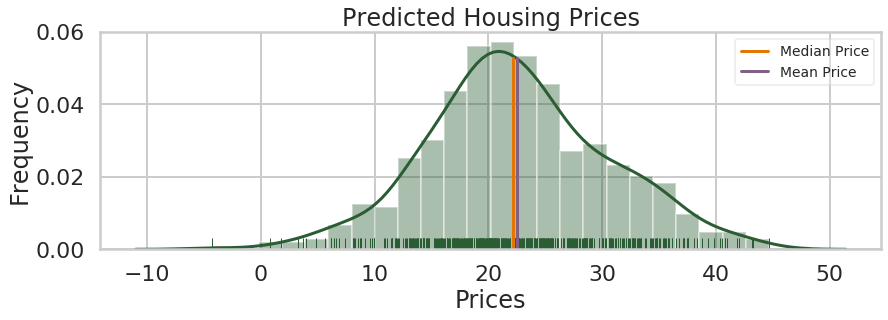

In [56]:
# plot predicted prices
figsize(14, 4)

sns.distplot(predicted_prices, bins=24, rug=True, axlabel='Prices', color=rgb[colors[4]])
plt.axvline(np.median(predicted_prices), ymin=0, ymax=0.88, label='Median Price', color=rgb[colors[5]])
plt.axvline(np.mean(predicted_prices), ymin=0, ymax=0.88, label='Mean Price', color=rgb[colors[1]])

plt.ylabel('Frequency')

plt.legend(loc=1, fontsize='xx-small', framealpha=0.3)
plt.title('Predicted Housing Prices');

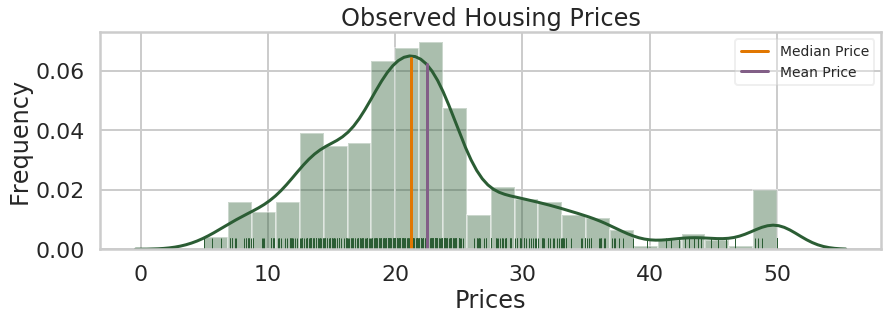

In [57]:
# plot predicted prices
figsize(14, 4)

sns.distplot(bos.PRICE, bins=24, rug=True, axlabel='Prices', color=rgb[colors[4]])
plt.axvline(np.median(bos.PRICE), ymin=0, ymax=0.88, label='Median Price', color=rgb[colors[5]])
plt.axvline(np.mean(bos.PRICE), ymin=0, ymax=0.85, label='Mean Price', color=rgb[colors[1]])

plt.ylabel('Frequency')

plt.legend(loc=1, fontsize='xx-small', framealpha=0.3)
plt.title('Observed Housing Prices');

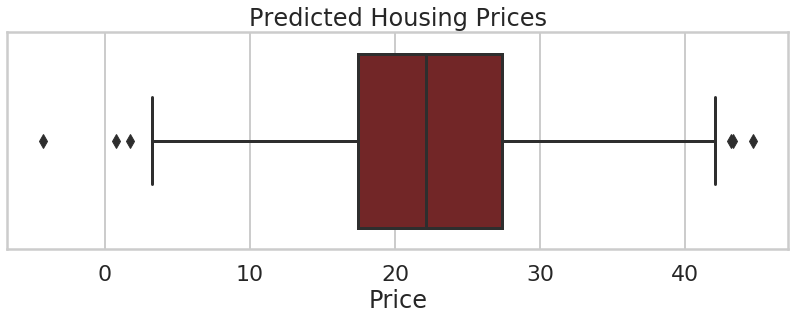

In [58]:
# plot predicted prices, look for outliers
figsize(14, 4)

sns.boxplot(predicted_prices, color=rgb[colors[2]], saturation=0.5, fliersize=10)

plt.xlabel('Price')

plt.title('Predicted Housing Prices');

The distribution is not quite normal. It is slightly skewed right, as observed by the median being less than the mean.<br>
It has heavy tails, as well, due to the extreme value outliers.<br>
The model did not emulate the $50,000 ceiling found in the original data, showing that these data points are unreliable.<br>
One outlier has a negative housing price.<br>
By chance, the model may have generated a sample with many negative correlations to the target variable.<br>
Since the model does not know that negative housing prices are out of bounds, it produced an instance.<br>
Also, we should be using unseen validation data to feed to the predict method, instead of feeding it the training data a second time.<br>
I'm not sure that anything special should be done with the outliers at this point. We don't even have a problem to solve so far.<br>
Once we have an objective for using this dataset, then it will be appropriate to make those choices.

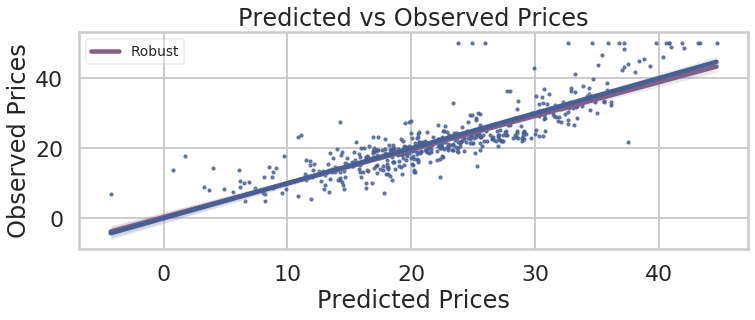

In [59]:
# plot scatterplot with regression line
figsize(12, 4)
# plot regression line weighing against outliers
sns.regplot(x=predicted_prices, y=bos.PRICE, scatter_kws={'s':10}, fit_reg = True, 
            color=rgb[colors[1]], label='Robust', robust=True, scatter=False)
# plot normal regression line
sns.regplot(x=predicted_prices, y=bos.PRICE, scatter_kws={'s':10}, fit_reg = True)

plt.xlabel('Predicted Prices')
plt.ylabel('Observed Prices')

plt.legend(loc=2, markerscale=2, fontsize='xx-small', framealpha=0.3)
plt.title('Predicted vs Observed Prices');

The regresion line that heavily penalizes outliers nearly matches the standard line.<br>
The outliers do not affect the predicted prices as much as when the number of rooms is the sole predictor.

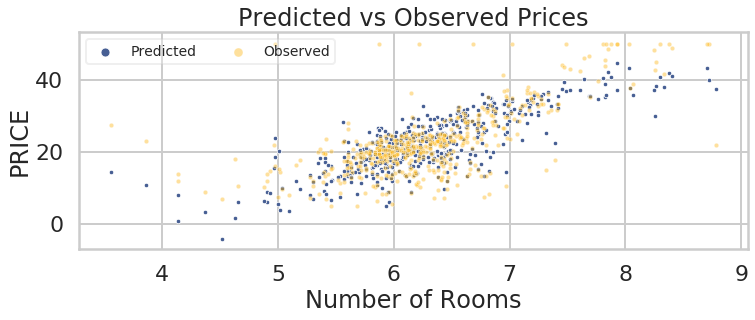

In [60]:
# plot scatterplot
figsize(12, 4)

sns.scatterplot(x=bos.RM, y=predicted_prices, s=20, label='Predicted')
sns.scatterplot(x=bos.RM, y=bos.PRICE, s=20, alpha= 0.4, color=rgb[colors[3]], label='Observed')

plt.xlabel('Number of Rooms')

plt.title('Predicted vs Observed Prices')
plt.legend(loc=2, ncol=2, markerscale=2, fontsize='xx-small', framealpha=0.3);

Making the comparision between predicted and observed prices each against one of the variables, shows the predictions are not as tightly grouped.<br>
Adding more predictors has diminished the overfitting when viewing the number of rooms vs. the housing prices.

Statsmodels has more built-in diagnostic tools for doing statistical testing.<br>
If you want to do those tests while using Scikit Learn, you have to code them yourself.<br>
The syntax of statsmodels is more aligned to R, while that of Scikit Learn is more pythonic.<br>
Implimentation of Scikit Learn follows a simpler, more cookie cutter, procedure than Statsmodels.<br>
It can be easily used with other pipeline features.<br>
I find it to be better documented, as well.

### Evaluating the Model: Sum-of-Squares

The partitioning of the sum-of-squares shows the variance in the predictions explained by the model and the variance that is attributed to error.

$$TSS = ESS + RSS$$

#### Residual Sum-of-Squares (aka $RSS$)

The residual sum-of-squares is one of the basic ways of quantifying how much error exists in the fitted model. We will revisit this in a bit.

$$ RSS = \sum_{i=1}^N r_i^2 = \sum_{i=1}^N \left(y_i - \left(\beta_0 + \beta_1 x_i\right)\right)^2 $$

In [61]:
print(np.sum((bos.PRICE - lm.predict(X)) ** 2))

11078.784577954977


#### Explained Sum-of-Squares (aka $ESS$)

The explained sum-of-squares measures the variance explained by the regression model.

$$ESS = \sum_{i=1}^N \left( \hat{y}_i - \bar{y} \right)^2 = \sum_{i=1}^N \left( \left( \hat{\beta}_0 + \hat{\beta}_1 x_i \right) - \bar{y} \right)^2$$

In [62]:
print(np.sum((lm.predict(X) - np.mean(bos.PRICE)) ** 2))

31637.510837064252


### Evaluating the Model: The Coefficient of Determination ($R^2$)

The coefficient of determination, $R^2$, tells us the percentage of the variance in the response variable $Y$ that can be explained by the linear regression model.

$$ R^2 = \frac{ESS}{TSS} $$

The $R^2$ value is one of the most common metrics that people use in describing the quality of a model, but it is important to note that *$R^2$ increases artificially as a side-effect of increasing the number of independent variables.* While $R^2$ is reported in almost all statistical packages, another metric called the *adjusted $R^2$* is also provided as it takes into account the number of variables in the model, and can sometimes even be used for non-linear regression models!

$$R_{adj}^2 = 1 - \left( 1 - R^2 \right) \frac{N - 1}{N - K - 1} = R^2 - \left( 1 - R^2 \right) \frac{K}{N - K - 1} = 1 - \frac{\frac{RSS}{DF_R}}{\frac{TSS}{DF_T}}$$

where $N$ is the number of observations, $K$ is the number of variables, $DF_R = N - K - 1$ is the degrees of freedom associated with the residual error and $DF_T = N - 1$ is the degrees of the freedom of the total error.

### Evaluating the Model: Mean Squared Error and the $F$-Statistic
***
The mean squared errors are just the *averages* of the sum-of-squares errors over their respective degrees of freedom.

$$MSE = \frac{RSS}{N-K-1}$$

$$MSR = \frac{ESS}{K}$$

**Remember:** Notation may vary across resources particularly the use of $R$ and $E$ in $RSS/ESS$ and $MSR/MSE$. In some resources, E = explained and R = residual. In other resources, E = error and R = regression (explained). **This is a very important distinction that requires looking at the formula to determine which naming scheme is being used.**

Given the MSR and MSE, we can now determine whether or not the entire model we just fit is even statistically significant. We use an $F$-test for this. The null hypothesis is that all of the $\beta$ coefficients are zero, that is, none of them have any effect on $Y$. The alternative is that *at least one* $\beta$ coefficient is nonzero, but it doesn't tell us which one in a multiple regression:

$$H_0: \beta_i = 0, \mbox{for all $i$} \\
H_A: \beta_i > 0, \mbox{for some $i$}$$ 

$$F = \frac{MSR}{MSE} = \left( \frac{R^2}{1 - R^2} \right) \left( \frac{N - K - 1}{K} \right)$$
 
Once we compute the $F$-statistic, we can use the $F$-distribution with $N-K$ and $K-1$ degrees of degrees of freedom to get a p-value.

**Warning!** The $F$-statistic mentioned in this section is NOT the same as the F1-measure or F1-value discused in Unit 7.

<div class="span5 alert alert-info">
<h3>Part 3 Checkup Exercise Set IV</h3>

<p>Let's look at the relationship between `PTRATIO` and housing price.</p>

<p><b>Exercise:</b> Try fitting a linear regression model using only the 'PTRATIO' (pupil-teacher ratio by town) and interpret the intercept and the coefficients.</p>

<p><b>Exercise:</b> Calculate (or extract) the $R^2$ value. What does it tell you?</p>

<p><b>Exercise:</b> Compute the $F$-statistic. What does it tell you?</p>

<p><b>Exercise:</b> Take a close look at the $F$-statistic and the $t$-statistic for the regression coefficient. What relationship do you notice? Note that this relationship only applies in *simple* linear regression models.</p>
</div>

In [63]:
# your turn


In [64]:
# create a LinearRegression object
class_model = LinearRegression()
class_model

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [65]:
# fit linear regression model using only class size predictor
class_model.fit(X[['PTRATIO']], bos.PRICE)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [66]:
# get the estimated intercept
f'Estimated intercept coefficient: {class_model.intercept_}'

'Estimated intercept coefficient: 62.34462747483265'

The hypothetical value of a house would be $62,344.63 if the pupil-to-teacher ratio was 0.<br>
That would be an infinite number of teaches. So, this value should not be interpreted as a possibility.<br>

In [67]:
f'The range of the observed class size is {bos.PTRATIO.min(), bos.PTRATIO.max()} students per teacher'

'The range of the observed class size is (12.6, 22.0) students per teacher'

This is the area of the predictions that should give realistic prices.

In [68]:
# show the number of coefficients
f'Number of coefficients: {len(class_model.coef_)}'

'Number of coefficients: 1'

In [69]:
# get the coefficient
f'The coefficient is {class_model.coef_[0]}.'

'The coefficient is -2.1571752960609643.'

A 1 unit increase in pupil-to-teacher ratio is associated with a decrease of $2,1571.75 in housing price.<br>
This seems correct, as areas with smaller class sizes have tend to have better outcomes in test scores and would hold more value to families. 

In [70]:
# get predicted prices and show first five
class_prices = class_model.predict(X[['PTRATIO']])
class_prices[0:5]

array([29.33984545, 23.9469072 , 23.9469072 , 22.00544944, 22.00544944])

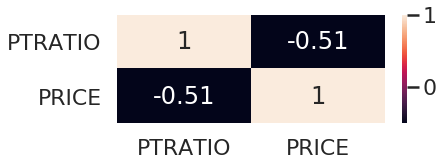

In [71]:
# use seaborn for correlations
figsize(6, 2)
sns.heatmap(bos[['PTRATIO', 'PRICE']].corr(),annot=True);

There is a correlation here, but not as strong as there was with the number of rooms.

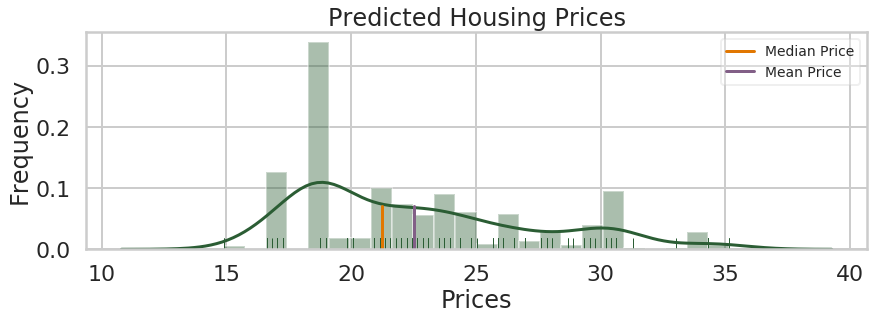

In [72]:
# plot predicted prices
figsize(14, 4)

sns.distplot(class_prices, bins=24, rug=True, axlabel='Prices', color=rgb[colors[4]])
plt.axvline(np.median(class_prices), ymin=0, ymax=0.2, label='Median Price', color=rgb[colors[5]])
plt.axvline(np.mean(class_prices), ymin=0, ymax=0.2, label='Mean Price', color=rgb[colors[1]])

plt.ylabel('Frequency')

plt.legend(loc=1, fontsize='xx-small', framealpha=0.3)
plt.title('Predicted Housing Prices');

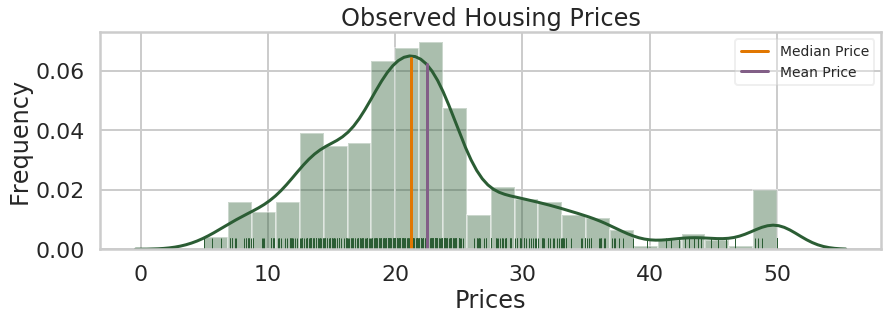

In [73]:
# plot predicted prices
figsize(14, 4)

sns.distplot(bos.PRICE, bins=24, rug=True, axlabel='Prices', color=rgb[colors[4]])
plt.axvline(np.median(bos.PRICE), ymin=0, ymax=0.88, label='Median Price', color=rgb[colors[5]])
plt.axvline(np.mean(bos.PRICE), ymin=0, ymax=0.85, label='Mean Price', color=rgb[colors[1]])

plt.ylabel('Frequency')

plt.legend(loc=1, fontsize='xx-small', framealpha=0.3)
plt.title('Observed Housing Prices');

This distribution looks nothing like the observed data.<br>
Class size is not a good choice to use if relying on a single variable to fit a model.

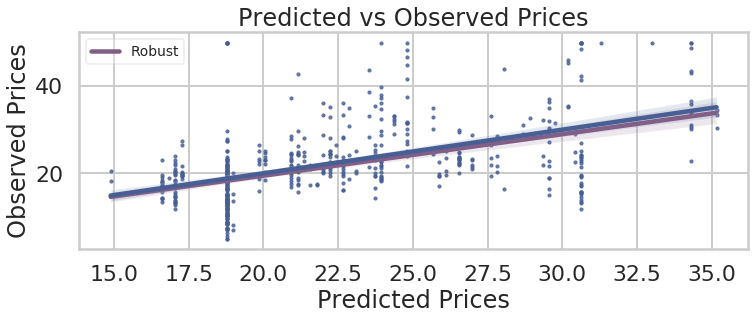

In [74]:
# plot scatterplot with regression line
figsize(12, 4)
# plot regression line weighing against outliers
sns.regplot(x=class_prices, y=bos.PRICE, scatter_kws={'s':10}, fit_reg = True, 
            color=rgb[colors[1]], label='Robust', robust=True, scatter=False)
# plot normal regression line
sns.regplot(x=class_prices, y=bos.PRICE, scatter_kws={'s':10}, fit_reg = True)

plt.xlabel('Predicted Prices')
plt.ylabel('Observed Prices')

plt.legend(loc=2, markerscale=2, fontsize='xx-small', framealpha=0.3)
plt.title('Predicted vs Observed Prices');

The negative housing price has disappeared with this model.<br>
One of the other variables in the full dataset may be contributing to this strange effect.

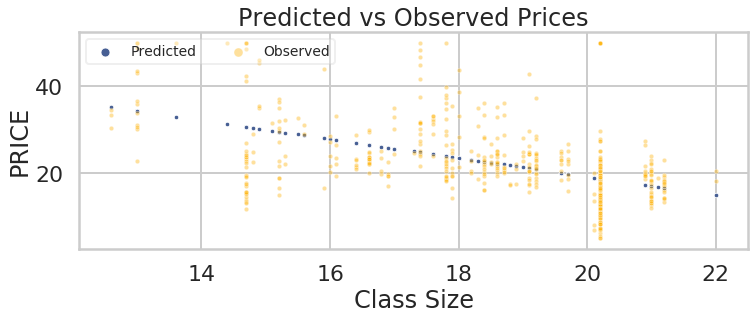

In [75]:
# plot scatterplot
figsize(12, 4)

sns.scatterplot(x=bos.PTRATIO, y=class_prices, s=20, label='Predicted')
sns.scatterplot(x=bos.PTRATIO, y=bos.PRICE, s=20, alpha= 0.4, color=rgb[colors[3]], label='Observed')

plt.xlabel('Class Size')

plt.title('Predicted vs Observed Prices')
plt.legend(loc=2, ncol=2, markerscale=2, fontsize='xx-small', framealpha=0.3);

Once again, the model is overfit due to using only one variable to make predictions.<br>

Now, I will look at the residuals.

In [76]:
# get array of residuals
class_residuals = bos.PRICE - class_prices
class_residuals[0:5]

0    -5.339845
1    -2.346907
2    10.753093
3    11.394551
4    14.194551
Name: PRICE, dtype: float64

In [77]:
# get the average of residuals
f'Residuals mean: {class_residuals.mean()}'

'Residuals mean: -1.129004663144507e-14'

The mean is close to zero, which is where we want it.

In [78]:
# get the median of residuals
f'Residuals median: {class_residuals.median()}'

'Residuals median: -0.6425793200682293'

In [79]:
# plot distribution of residuals
figsize(12, 4)

sns.distplot(class_residuals, bins=30, rug=True, axlabel='Residual', color=rgb[colors[4]])
plt.axvline(np.median(class_residuals), ymin=0, ymax=0.88, label='Median Residuals', color=rgb[colors[5]])
plt.axvline(np.mean(class_residuals), ymin=0, ymax=0.88, label='Mean Residuals', color=rgb[colors[1]])

plt.ylabel('Frequency')

plt.legend(loc=1, fontsize='xx-small', framealpha=0.3)
plt.title('Distribution of Residuals');

The distibution does not look normal. There is a heavy tail, and it is skewed right.

In [80]:
# test for normal distribution of residuals
f'p-value: {stats.normaltest(class_residuals)[1]}'

'p-value: 6.634966130705191e-21'

It is highly unlikely that the residual distribution would have been randomly drawn from a normal distribution.

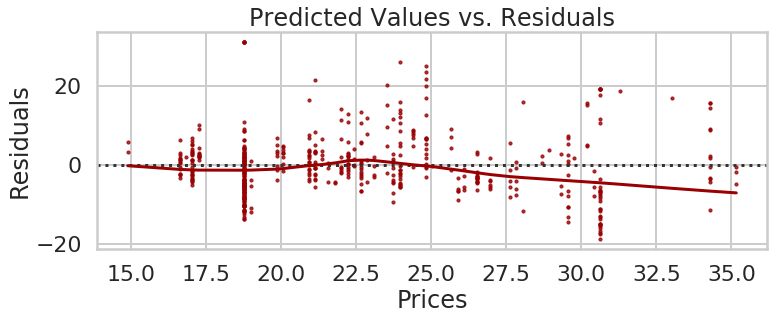

In [81]:
# look at the residuals plot
figsize(12, 4)

sns.residplot(class_prices, bos.PRICE, lowess=True, scatter_kws={'s':10}, 
              color=rgb[colors[2]], line_kws={'linewidth':3})

plt.xlabel('Prices')
plt.ylabel('Residuals')

plt.title('Predicted Values vs. Residuals');

A few clusters are observed, which is understandable given that the observed data is discrete.<br>
The curve dips negative for higher housing prices, suggesting that this model may be underfit.<br>
There are no sharp bends in the curve that would suggest nonlinear patterns in the data.<br>
Therefore, the choice of a linear regression versus one of a higher order is sound.

I will calculate the $R^2$ value and F statistic "by hand".

In [82]:
# define number of observations variable
N = len(bos.PRICE)
N

506

In [83]:
# get the explained sum of squares (ESS)
explained_ss = np.sum((class_prices - np.mean(bos.PRICE)) ** 2)
explained_ss

11014.282208052498

In [84]:
# get the residual sum of squares (RSS)
residual_ss = np.sum(class_residuals ** 2)
residual_ss

31702.013206967255

In [85]:
# get the mean squared regression (MSR)
ms_regression = explained_ss / 1
ms_regression

11014.282208052498

In [86]:
# get the mean squared error (MSE)
ms_error = residual_ss / (N - 1 - 1)
ms_error

62.90081985509376

In [87]:
# get the explained variance score
r2 = explained_ss / (explained_ss + residual_ss)
r2

0.25784731800922267

In [88]:
# get the F-statistic
f_stat = ms_regression / ms_error
f_stat

175.10554287569516

Now, I will generate these values with function calls.

In [89]:
# generate the explained variance score
class_r2 = metrics.r2_score(bos.PRICE, class_prices)
f'The R\u00b2 score is {class_r2}.'

'The R² score is 0.257847318009223.'

In [90]:
# confirm this value another way
f'EVS: {metrics.explained_variance_score(bos.PRICE, class_prices)}'

'EVS: 0.257847318009223'

Looking at the $R^2$ value, the model only explains about a quarter of the variance in the observed data.<br>
This would imply that using class size as the only predictor variable will not result in a well fitted model.

In [91]:
# get at the F-statistic
class_f_stat = (class_r2/(1 - class_r2)) * (N - 1 - 1)
class_f_stat

175.10554287569548

Under the null hypothesis (a model with no independent variables fits the data as well as our model), this would be small.<br>
The number, by itself, is not enough to reject the null hypothesis. It is the test statistic for the F-test.

Now I will calculate the t-statistic "by hand".

In [92]:
# get sum of squares for predictor variable
class_ss = np.sum((bos.PTRATIO - np.mean(bos.PTRATIO)) ** 2)
class_ss

2366.9295059288534

In [93]:
# get standard error for predictor variable
se_class = np.sqrt(ms_error / class_ss)
se_class

0.16301797395743503

In [94]:
# get t-statistic for predictor variable
t_class = class_model.coef_[0] / se_class
t_class

-13.232745099777867

In [95]:
# get p-value for predictor variable
p_class = stats.t.cdf(t_class, df=(N - 1 - 1))
p_class

8.047547392364884e-35

This small value tells us that we can reject the null hypothesis<br>
It is highly unlikely that a model with no independent variables would fit the data as well as our model.

In [96]:
# observe relation between t-statistic and f-stastic
t_class ** 2 == f_stat

True

Now, I will confirm this quickly with Statsmodels summary report.

In [97]:
# use one-liner to get stats
ols('PRICE ~ PTRATIO', bos).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  PRICE   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.256
Method:                 Least Squares   F-statistic:                     175.1
Date:                Tue, 12 May 2020   Prob (F-statistic):           1.61e-34
Time:                        23:48:13   Log-Likelihood:                -1764.8
No. Observations:                 506   AIC:                             3534.
Df Residuals:                     504   BIC:                             3542.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     62.3446      3.029     20.581      0.000      56.393      68.296
PTRATIO       -2.1572      0.163    -13.233      0.000      -2.477      -1.837
==============================================================================
Omnibus:                       92.924   Durbin-Watson:                   0.725
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              191.444
Skew:                           1.001   Prob(JB):                     2.68e-42
Kurtosis:                       5.252   Cond. No.                         160.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Both modules produce the same results, although Scikit Learn makes you earn it.

<div class="span5 alert alert-info">
<h3>Part 3 Checkup Exercise Set V</h3>

<p>Fit a linear regression model using three independent variables</p>

<ol>
<li> 'CRIM' (per capita crime rate by town)
<li> 'RM' (average number of rooms per dwelling)
<li> 'PTRATIO' (pupil-teacher ratio by town)
</ol>

<p><b>Exercise:</b> Compute or extract the $F$-statistic. What does it tell you about the model?</p>

<p><b>Exercise:</b> Compute or extract the $R^2$ statistic. What does it tell you about the model?</p>

<p><b>Exercise:</b> Which variables in the model are significant in predicting house price? Write a story that interprets the coefficients.</p>
</div>

In [98]:
# your turn

Let's look at the data again.

In [99]:
# plot scatterplot of independent variables vs dependernt variable

sns.pairplot(bos, x_vars=['CRIM', 'RM', 'PTRATIO'], y_vars='PRICE', kind='reg', 
             height=4, aspect=1.25, plot_kws={'scatter_kws':{'s':5, 'color':rgb[colors[1]]}})

plt.suptitle('Predictors vs Target', fontdict={'size':30})
plt.subplots_adjust(top=0.8);

Crime rate and class size seem to be slightly negatively correlated to housing prices, and number of rooms is positively correlated to housing prices.<br>
There is a large swing in the confidence interval for the regression line of the crime variable,

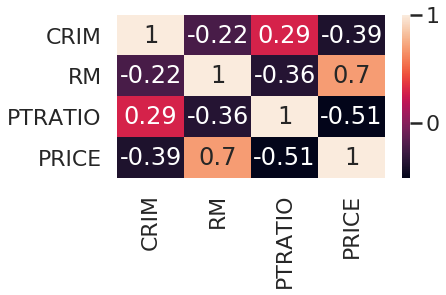

In [100]:
# use seaborn for correlations
figsize(6, 3)
sns.heatmap(bos[['CRIM', 'RM', 'PTRATIO', 'PRICE']].corr(),annot=True);

The room size should be the best predictor variable, and crime should be the worst.

Now, I will perform a linear regression evaluation.

In [101]:
# instantiate the model using statsmodels
model = ols('PRICE ~ CRIM + RM + PTRATIO', bos)

In [102]:
# fit the model
fitted = model.fit()
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.594
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     245.2
Date:                Tue, 12 May 2020   Prob (F-statistic):           6.15e-98
Time:                        23:48:14   Log-Likelihood:                -1612.0
No. Observations:                 506   AIC:                             3232.
Df Residuals:                     502   BIC:                             3249.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.3707      4.034     -0.836      0.4

In [103]:
# generate the explained variance score
f'The R\u00b2 score is {fitted.rsquared}.'

'The R² score is 0.5943412940723474.'

The variance of the observed prices is better captured by this model than it was using one variable.

In [104]:
# get the f-statistic
fitted.fvalue

245.16449030064646

In [105]:
# get the p_value for the F-test
fitted.f_pvalue

6.150435026236491e-98

This null hypothesis is even less likely, now that we have used more variables in the model.

In [106]:
# get the t-values
fitted.tvalues

Intercept    -0.835612
CRIM         -6.398904
RM           18.381756
PTRATIO      -8.051244
dtype: float64

These statistics match what was observed in the correlation matrix.<br>
The number of rooms is the best predictor of housing prices.

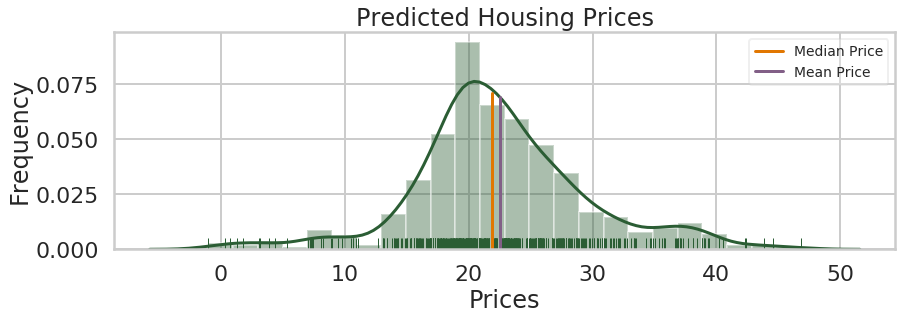

In [107]:
# plot predicted prices
figsize(14, 4)

sns.distplot(fitted.fittedvalues, bins=24, rug=True, axlabel='Prices', color=rgb[colors[4]])
plt.axvline(np.median(fitted.fittedvalues), ymin=0, ymax=0.72, label='Median Price', color=rgb[colors[5]])
plt.axvline(np.mean(fitted.fittedvalues), ymin=0, ymax=0.7, label='Mean Price', color=rgb[colors[1]])

plt.ylabel('Frequency')

plt.legend(loc=1, fontsize='xx-small', framealpha=0.3)
plt.title('Predicted Housing Prices');

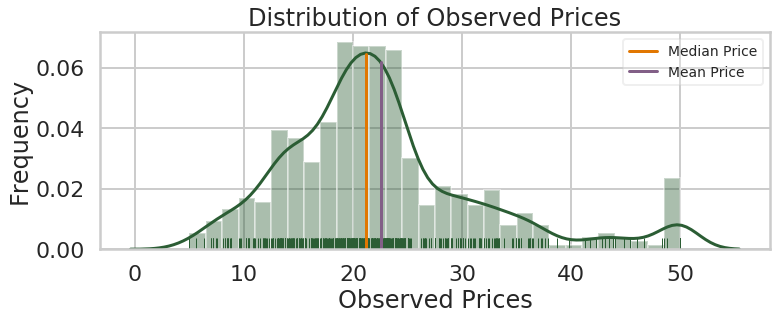

In [108]:
# plot distribution of target variable
figsize(12, 4)

sns.distplot(bos.PRICE, bins=30, rug=True, axlabel='Observed Prices', color=rgb[colors[4]])
plt.axvline(np.median(bos.PRICE), ymin=0, ymax=0.9, label='Median Price', color=rgb[colors[5]])
plt.axvline(np.mean(bos.PRICE), ymin=0, ymax=0.86, label='Mean Price', color=rgb[colors[1]])

plt.ylabel('Frequency')

plt.legend(loc=1, fontsize='xx-small', framealpha=0.3)
plt.title('Distribution of Observed Prices');

Visually, the fit appears better.

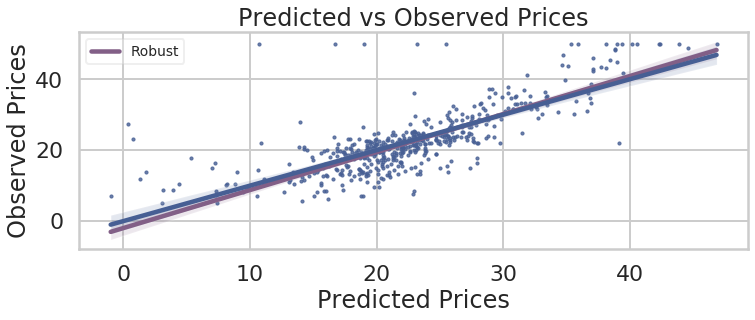

In [109]:
# plot scatterplot with regression line
figsize(12, 4)
# plot regression line weighing against outliers
sns.regplot(x=fitted.fittedvalues, y=bos.PRICE, scatter_kws={'s':10}, fit_reg = True, 
            color=rgb[colors[1]], label='Robust', robust=True, scatter=False)
# plot normal regression line
sns.regplot(x=fitted.fittedvalues, y=bos.PRICE, scatter_kws={'s':10}, fit_reg = True)

plt.xlabel('Predicted Prices')
plt.ylabel('Observed Prices')

plt.legend(loc=2, markerscale=2, fontsize='xx-small', framealpha=0.3)
plt.title('Predicted vs Observed Prices');

We are still getting a negative housing price.

## Part 4: Comparing Models

During modeling, there will be times when we want to compare models to see which one is more predictive or fits the data better. There are many ways to compare models, but we will focus on two.

### The $F$-Statistic Revisited

The $F$-statistic can also be used to compare two *nested* models, that is, two models trained on the same dataset where one of the models contains a *subset* of the variables of the other model. The *full* model contains $K$ variables and the *reduced* model contains a subset of these $K$ variables. This allows us to add additional variables to a base model and then test if adding the variables helped the model fit.

$$F = \frac{\left( \frac{RSS_{reduced} - RSS_{full}}{DF_{reduced} - DF_{full}} \right)}{\left( \frac{RSS_{full}}{DF_{full}} \right)}$$

where $DF_x = N - K_x - 1$ where $K_x$ is the number of variables in model $x$.

### Akaike Information Criterion (AIC)

Another statistic for comparing two models is AIC, which is based on the likelihood function and takes into account the number of variables in the model.

$$AIC = 2 K - 2 \log_e{L}$$

where $L$ is the likelihood of the model. AIC is meaningless in the absolute sense, and is only meaningful when compared to AIC values from other models. Lower values of AIC indicate better fitting models.

`statsmodels` provides the AIC in its output.

<div class="span5 alert alert-info">
<h3>Part 4 Checkup Exercises</h3>

<p><b>Exercise:</b> Find another variable (or two) to add to the model we built in Part 3. Compute the $F$-test comparing the two models as well as the AIC. Which model is better?</p>
</div>

Let's add the poverty variable.

In [110]:
# instantiate the model using statsmodels
model_1 = ols('PRICE ~ CRIM + RM + PTRATIO + LSTAT', bos)

In [111]:
# fit the model
fitted_1 = model_1.fit()
print(fitted_1.summary())

                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.679
Method:                 Least Squares   F-statistic:                     268.0
Date:                Tue, 12 May 2020   Prob (F-statistic):          5.84e-123
Time:                        23:48:22   Log-Likelihood:                -1550.8
No. Observations:                 506   AIC:                             3112.
Df Residuals:                     501   BIC:                             3133.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     16.9233      3.976      4.257      0.0

In [112]:
# get the explained variance score
r2_1 = metrics.r2_score(bos.PRICE, fitted_1.fittedvalues)
r2_1

0.6814923476854233

Adding the poverty variable increased the $R^2$ score a significant amount.

Let's add the distance from employment centers variable.

In [113]:
# instantiate the model using statsmodels
model_2 = ols('PRICE ~ CRIM + RM + PTRATIO + LSTAT + DIS', bos)

In [114]:
# fit the model
fitted_2 = model_2.fit()
print(fitted_2.summary())

                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.696
Model:                            OLS   Adj. R-squared:                  0.693
Method:                 Least Squares   F-statistic:                     228.7
Date:                Tue, 12 May 2020   Prob (F-statistic):          1.10e-126
Time:                        23:48:22   Log-Likelihood:                -1539.2
No. Observations:                 506   AIC:                             3090.
Df Residuals:                     500   BIC:                             3116.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     22.8945      4.080      5.611      0.0

In [115]:
# get the explained variance score
r2_2 = metrics.r2_score(bos.PRICE, fitted_2.fittedvalues)
r2_2

0.6957749733021503

There's not much gain when adding the distance from employment centers variable after adding the poverty variable.

In [116]:
# get the residual sum of squares (RSS) for first regression
rss_0 = np.sum((bos.PRICE - fitted.fittedvalues) ** 2)
rss_0

17328.237120080248

In [117]:
# get the residual sum of squares (RSS) for second regression
rss_1 = np.sum((bos.PRICE - fitted_1.fittedvalues) ** 2)
rss_1

13605.466968213861

In [118]:
# get the residual sum of squares (RSS) for third regression
rss_2 = np.sum((bos.PRICE - fitted_2.fittedvalues) ** 2)
rss_2

12995.366113067623

From observing the residuals, I can see that the error decreased the most when adding the poverty variable.

Now, I'll calculate the F statistics.

In [119]:
# get F-statistic between first and second model
delta_df_01 = 1
K_01 = 4
f_01 = (rss_0 - rss_1) * (N - K_01 - 1) / (rss_1 * delta_df_01)
f_01

137.08517689561617

In [120]:
# get F-statistic between first and third model
delta_df_02 = 2
K_02 = 5
f_02 = (rss_0 - rss_2) * (N - K_02 - 1) / (rss_2 * delta_df_02)
f_02

83.35415426764435

In [121]:
# get F-statistic between second and third model
delta_df_12 = 1
K_12 = 5
f_12 = (rss_1 - rss_2) * (N - K_12 - 1) / (rss_2 * delta_df_12)
f_12

23.473784802905442

The largest gain was when the poverty variable was added.

In [122]:
# get p value between first and second model
p_01 = 1 - stats.f.cdf(f_01, dfn=delta_df_01, dfd=(N - K_01 - 1))
p_01

1.1102230246251565e-16

In [123]:
# get p value between first and third model
p_02 = 1 - stats.f.cdf(f_02, dfn=delta_df_02, dfd=(N - K_02 - 1))
p_02

1.1102230246251565e-16

In [124]:
# get p value between second and third model
p_12 = 1 - stats.f.cdf(f_12, dfn=delta_df_12, dfd=(N - K_12 - 1))
p_12

1.6918562475431997e-06

There is realtively nothing to gain by adding the distance to employment centers variable.

In [125]:
# get AIC for model with three variables
model.fit().aic

3231.9451235449956

In [126]:
# get AIC for model with four variables
model_1.fit().aic

3111.5610897408874

In [127]:
# get AIC for model with five variables
model_2.fit().aic

3090.3463896931744

The best fitting model is the one with both variables added.


## Part 5: Evaluating the Model via Model Assumptions and Other Issues
***
Linear regression makes several assumptions. It is always best to check that these assumptions are valid after fitting a linear regression model.

<div class="span5 alert alert-danger">
<ul>
  <li>**Linearity**. The dependent variable $Y$ is a linear combination of the regression coefficients and the independent variables $X$. This can be verified with a scatterplot of each $X$ vs. $Y$ and plotting correlations among $X$. Nonlinearity can sometimes be resolved by [transforming](https://onlinecourses.science.psu.edu/stat501/node/318) one or more independent variables, the dependent variable, or both. In other cases, a [generalized linear model](https://en.wikipedia.org/wiki/Generalized_linear_model) or a [nonlinear model](https://en.wikipedia.org/wiki/Nonlinear_regression) may be warranted.</li>
  <li>**Constant standard deviation**. The SD of the dependent variable $Y$ should be constant for different values of X. We can check this by plotting each $X$ against $Y$ and verifying that there is no "funnel" shape showing data points fanning out as $X$ increases or decreases. Some techniques for dealing with non-constant variance include weighted least squares (WLS), [robust standard errors](https://en.wikipedia.org/wiki/Heteroscedasticity-consistent_standard_errors), or variance stabilizing transformations.
    </li>
  <li> **Normal distribution for errors**.  The $\epsilon$ term we discussed at the beginning are assumed to be normally distributed. This can be verified with a fitted values vs. residuals plot and verifying that there is no pattern, and with a quantile plot.
  $$ \epsilon_i \sim N(0, \sigma^2)$$
Sometimes the distributions of responses $Y$ may not be normally distributed at any given value of $X$.  e.g. skewed positively or negatively. </li>
<li> **Independent errors**.  The observations are assumed to be obtained independently.
    <ul>
        <li>e.g. Observations across time may be correlated
    </ul>
</li>
</ul>  

</div>

There are some other issues that are important investigate with linear regression models.

<div class="span5 alert alert-danger">
<ul>
  <li>**Correlated Predictors:** Care should be taken to make sure that the independent variables in a regression model are not too highly correlated. Correlated predictors typically do not majorly affect prediction, but do inflate standard errors of coefficients making interpretation unreliable. Common solutions are dropping the least important variables involved in the correlations, using regularlization, or, when many predictors are highly correlated, considering a dimension reduction technique such as principal component analysis (PCA).
  <li>**Influential Points:** Data points that have undue influence on the regression model. These points can be high leverage points or outliers. Such points are typically removed and the regression model rerun.
</ul>
</div>


<div class="span5 alert alert-info">
<h3>Part 5 Checkup Exercises</h3>

<p>Take the reduced model from Part 3 to answer the following exercises. Take a look at [this blog post](http://mpastell.com/2013/04/19/python_regression/) for more information on using statsmodels to construct these plots.</p>
    
<p><b>Exercise:</b> Construct a fitted values versus residuals plot. What does the plot tell you? Are there any violations of the model assumptions?</p>

<p><b>Exercise:</b> Construct a quantile plot of the residuals. What does the plot tell you?</p>

<p><b>Exercise:</b> What are some advantages and disadvantages of the fitted vs. residual and quantile plot compared to each other?</p>

<p><b>Exercise:</b> Identify any outliers (if any) in your model and write a story describing what these outliers might represent.</p>

<p><b>Exercise:</b> Construct a leverage plot and identify high leverage points in the model. Write a story explaining possible reasons for the high leverage points.</p>

<p><b>Exercise:</b> Remove the outliers and high leverage points from your model and run the regression again. How do the results change?</p>
</div>

In [128]:
# Your turn.


I will copy the plot I previously made.

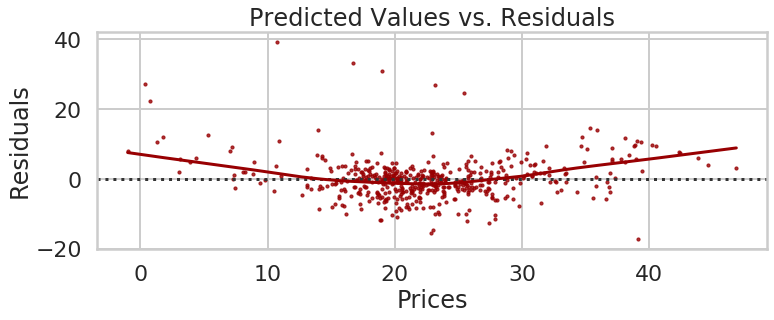

In [129]:
# look at the residuals plot
figsize(12, 4)

sns.residplot(fitted.fittedvalues, bos.PRICE, lowess=True, scatter_kws={'s':10}, 
              color=rgb[colors[2]], line_kws={'linewidth':3})

plt.xlabel('Prices')
plt.ylabel('Residuals')

plt.title('Predicted Values vs. Residuals');

In [130]:
# look for extreme data ranges
bos[['CRIM', 'RM', 'PTRATIO']].describe()

CRIM          RM     PTRATIO
count  506.000000  506.000000  506.000000
mean     3.613524    6.284634   18.455534
std      8.601545    0.702617    2.164946
min      0.006320    3.561000   12.600000
25%      0.082045    5.885500   17.400000
50%      0.256510    6.208500   19.050000
75%      3.677083    6.623500   20.200000
max     88.976200    8.780000   22.000000

The residuals cluster above the regression line for small and large values of housing prices.<br>
This suggests that the variances of the residuals are unequal, resulting in heteroscedasticity.<br>
One reason for this may be the extreme range that the crime variable has.<br>
Error variances change more with larger values, and the minimum and maximum crime data differ by a factor of four.<br>
Also, the outliers are clear to observe.

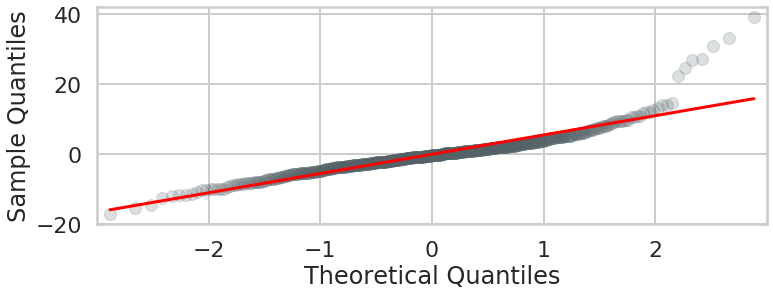

In [131]:
# get quantile-quantile plot
qqplot(fitted.resid, line='r', c=rgb[colors[6]], alpha=0.2)
plt.show()

The distribution fits the normal quantiles until it gets to higher values.<br>
This suggests that there are high valued outliers, which have values that are more extreme than ones drawn from a normal distribution.

The fitted vs residuals plot is good for detecting heteroscedasticity in the errors and clearly shows outliers<br>
The QQ plot is good for visualizing how data deviates from a known distribution, although it lacks for detail near the mean values.

As noted during EDA, the data is unreliable, because it was censored to have a maximum ceiling of $50,000.<br>
All of the true values that were above that cap, were recorded at that value. This results in data that can not be fit to a normal distribution.<br>
This is the reason for the high priced outliers in the predicted values.

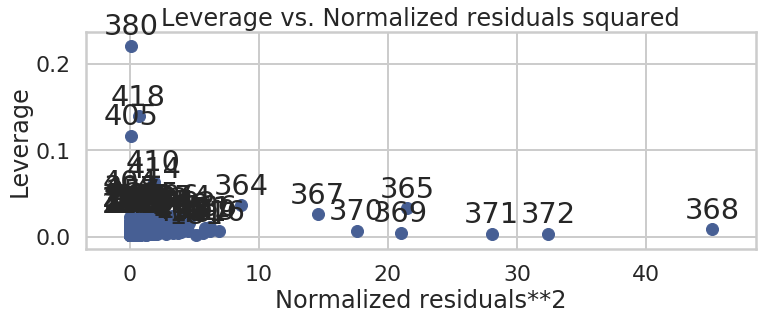

In [132]:
# get leverage plot
sm.graphics.plot_leverage_resid2(fitted)
plt.show()

We are looking for values in the upper left and lower right corners.<br>
In the upper left corner, we have values with high leverage values, but low normalized residuals.<br>
Small changes in these values result in large changes in the regression model, even though they are close to the regression line.<br>
In the lower right corner, we have values with high normalized residuals, but lower leverage values.<br>
The model is not as sensitive to small changes in these values, even though they are not close to the regression line.<br>
There are no values that have both high leverage values and high normalized residuals.

In [133]:
# get average variables to see if any variables are out of range
bos[['CRIM', 'RM', 'PTRATIO', 'PRICE']].mean()

CRIM        3.613524
RM          6.284634
PTRATIO    18.455534
PRICE      22.532806
dtype: float64

I will inspect the houses with the highest leverage values.

In [134]:
# look at highest leverage prediction
fitted.fittedvalues[380], bos[['CRIM', 'RM', 'PTRATIO', 'PRICE']].iloc[380]

(8.214532947928895,
 CRIM       88.9762
 RM          6.9680
 PTRATIO    20.2000
 PRICE      10.4000
 Name: 380, dtype: float64)

In [135]:
# look at second highest leverage prediction
fitted.fittedvalues[418], bos[['CRIM', 'RM', 'PTRATIO', 'PRICE']].iloc[418]

(3.9179630051367553,
 CRIM       73.5341
 RM          5.9570
 PTRATIO    20.2000
 PRICE       8.8000
 Name: 418, dtype: float64)

These houses both have very high crime rates.

In [136]:
# get houses with the highest crime rates
bos.CRIM.sort_values(ascending=False)[:5]

380    88.9762
418    73.5341
405    67.9208
410    51.1358
414    45.7461
Name: CRIM, dtype: float64

The houses with the highest crime rates are exactly the houses with the highest leverage values.<br>
I believe high crime values are allowing these observations to have strong leverage over the model.

I will inspect the houses with the largest residuals.

In [137]:
# get houses with the largest residuals
fitted.resid.sort_values(ascending=False)[:5]

368    39.298836
372    33.310083
371    30.991160
365    27.127667
369    26.814372
dtype: float64

In [138]:
# look at largest residual
fitted.fittedvalues[368], bos[['CRIM', 'RM', 'PTRATIO', 'PRICE']].iloc[368]

(10.701164403807514,
 CRIM        4.89822
 RM          4.97000
 PTRATIO    20.20000
 PRICE      50.00000
 Name: 368, dtype: float64)

In [139]:
# look at second largest residual
fitted.fittedvalues[372], bos[['CRIM', 'RM', 'PTRATIO', 'PRICE']].iloc[372]

(16.689917257163682,
 CRIM        8.26725
 RM          5.87500
 PTRATIO    20.20000
 PRICE      50.00000
 Name: 372, dtype: float64)

In [140]:
# look at third largest residual
fitted.fittedvalues[371], bos[['CRIM', 'RM', 'PTRATIO', 'PRICE']].iloc[371]

(19.00883999161938,
 CRIM        9.2323
 RM          6.2160
 PTRATIO    20.2000
 PRICE      50.0000
 Name: 371, dtype: float64)

The values for these houses are near the average values for predictors, except for their prices.<br>
They all have observed prices that are too large for their size and crime values.<br>
These overvalued houses may be spreading out the range of the values in that group.<br>
This is probably happening in conjunction with houses the survey has underpriced at $50,000, which have feature values more desirable to home owners.<br>
Houses at the ceiling have a wider range of values than other houses have that are similarly priced.

In [141]:
# get number of houses at $50.000
np.sum([bos.PRICE == 50])

16

Removing all of the houses valued at $50,000 may be appropriate, as these observations can not be sorted out very easily, and they are relatively few.

Checking with the Cook's distance measure.<br>
The general rule is to look for predicted values with a Cook's distance of greater than 0.5 to identify influencial outliers.

In [142]:
# get maximum Cook's distance
np.max(OLSInfluence(fitted).cooks_distance[0])

0.18973755399419195

Another rule of thumb is to look for values with a Cook's distance that is greater than 3 times the mean of the predicted values.

In [143]:
# look for outliers with a Cook's distance over 3 time greater than the standard deviation of the predicted values
np.sum(np.max(OLSInfluence(fitted).cooks_distance[0]) > (3 * np.mean(fitted.fittedvalues)))

0

None of the predicted values meet neither of these criteria.<br>
The Cook's distances do not raise any red flags signaling significant outliers.<br>
The Cook's distance measures the combined effecrt of high leverage and high residual<br>
We can not rule out a strong effect coming from only one of these influences.

I will run the model without the ceiling houses, then without the outliers, and then without the high leverage valued observations, and observe the differences.

I will remove the houses at the ceiling, first.

In [144]:
# get rows to drop
no50_lst = bos[bos.PRICE == 50].index.tolist()
no50_lst[:5]

[161, 162, 163, 166, 186]

In [145]:
# drop ceiling observations from DataFrame
bos_no50 = bos.drop(no50_lst)
bos_no50.head()

CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   PTRATIO       B  LSTAT  PRICE  
0     15.3  396.90   4.98   24.0  
1     17.8  396.90   9.14   21.6  
2     17.8  392.83   4.03   34.7  
3     18.7  394.63   2.94   33.4  
4     18.7  396.90   5.33   36.2

In [146]:
# instantiate the model using statsmodels
model_no50 = ols('PRICE ~ CRIM + RM + PTRATIO', bos_no50)

In [147]:
# fit the model
fitted_no50 = model_no50.fit()
print(fitted_no50.summary())

                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.637
Model:                            OLS   Adj. R-squared:                  0.634
Method:                 Least Squares   F-statistic:                     283.8
Date:                Tue, 12 May 2020   Prob (F-statistic):          2.10e-106
Time:                        23:48:23   Log-Likelihood:                -1457.4
No. Observations:                 490   AIC:                             2923.
Df Residuals:                     486   BIC:                             2940.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0106      3.327      0.304      0.7

In [148]:
# generate the explained variance score
f'The R\u00b2 score is {fitted_no50.rsquared}.'

'The R² score is 0.6365982290310864.'

The $R^2$ score has improved by 4%.

In [149]:
# generate the F-statistic
f'The F-statistic is {fitted_no50.fvalue}.'

'The F-statistic is 283.7875908751638.'

The F-statistic has increased by 38.5 points.

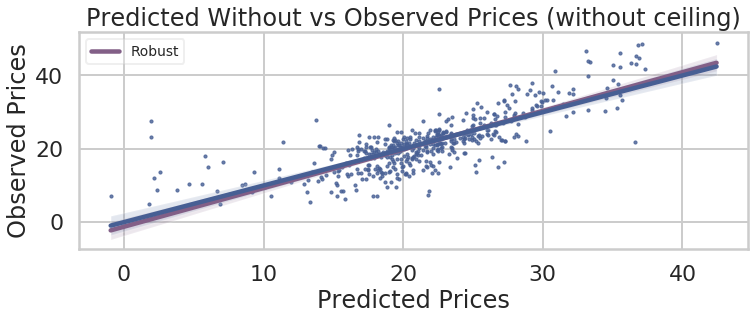

In [150]:
# plot scatterplot with regression line
figsize(12, 4)
# plot regression line weighing against outliers
sns.regplot(x=fitted_no50.fittedvalues, y=bos_no50.PRICE, scatter_kws={'s':10}, fit_reg = True, 
            color=rgb[colors[1]], label='Robust', robust=True, scatter=False)
# plot normal regression line
sns.regplot(x=fitted_no50.fittedvalues, y=bos_no50.PRICE, scatter_kws={'s':10}, fit_reg = True)

plt.xlabel('Predicted Prices')
plt.ylabel('Observed Prices')

plt.legend(loc=2, markerscale=2, fontsize='xx-small', framealpha=0.3)
plt.title('Predicted Without vs Observed Prices (without ceiling)');

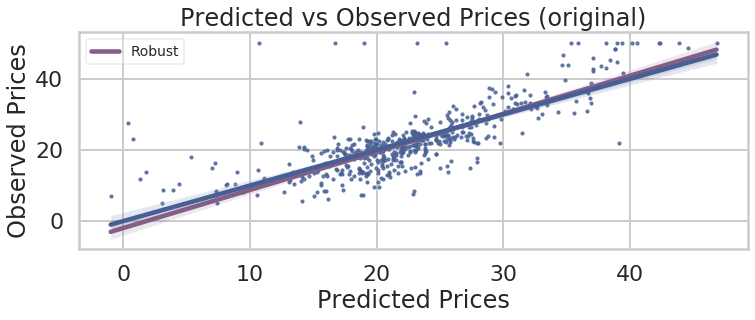

In [151]:
# plot scatterplot with regression line
figsize(12, 4)
# plot regression line weighing against outliers
sns.regplot(x=fitted.fittedvalues, y=bos.PRICE, scatter_kws={'s':10}, fit_reg = True, 
            color=rgb[colors[1]], label='Robust', robust=True, scatter=False)
# plot normal regression line
sns.regplot(x=fitted.fittedvalues, y=bos.PRICE, scatter_kws={'s':10}, fit_reg = True)

plt.xlabel('Predicted Prices')
plt.ylabel('Observed Prices')

plt.legend(loc=2, markerscale=2, fontsize='xx-small', framealpha=0.3)
plt.title('Predicted vs Observed Prices (original)');

The ceiling has been eliminated from the predicted prices. The regression line is more aligned with a robust plotting.

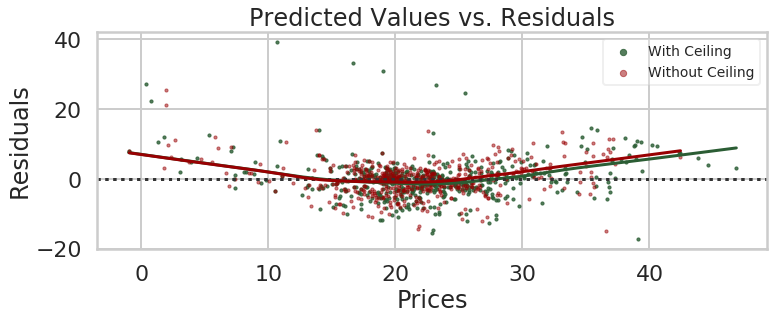

In [152]:
# look at the residuals plots
figsize(12, 4)

sns.residplot(fitted.fittedvalues, bos.PRICE, lowess=True, scatter_kws={'s':10}, 
              color=rgb[colors[4]], line_kws={'linewidth':3}, label='With Ceiling')
sns.residplot(fitted_no50.fittedvalues, bos_no50.PRICE, lowess=True, scatter_kws={'s':10, 'alpha':0.5}, 
              color=rgb[colors[2]], line_kws={'linewidth':3}, label='Without Ceiling')

plt.xlabel('Prices')
plt.ylabel('Residuals')

plt.legend(loc=1, markerscale=2, fontsize='xx-small', framealpha=0.3)
plt.title('Predicted Values vs. Residuals');

The outliers have been removed, but the residuals are still unbalanced.

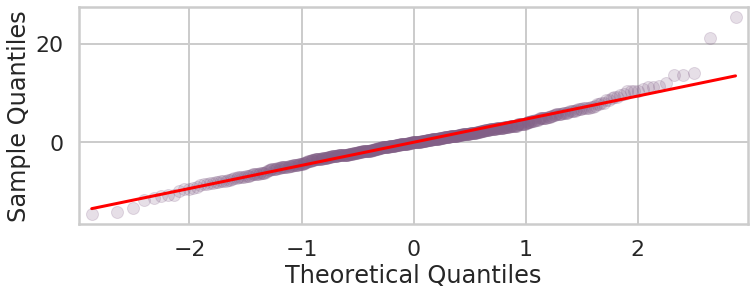

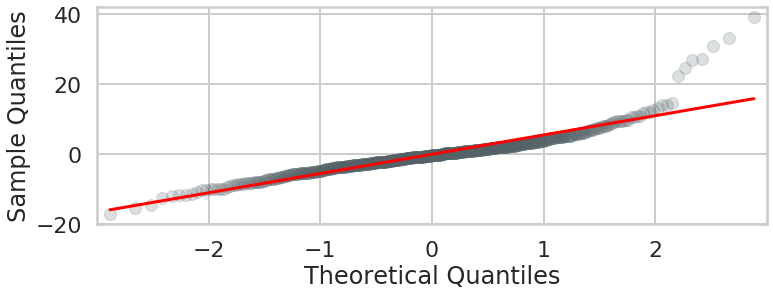

In [153]:
# get quantile-quantile plots
qqplot(fitted_no50.resid, line='r', c=rgb[colors[1]], alpha=0.2)
qqplot(fitted.resid, line='r', c=rgb[colors[6]], alpha=0.2)
plt.show()

The extreme values are now closer to a normal distribution.

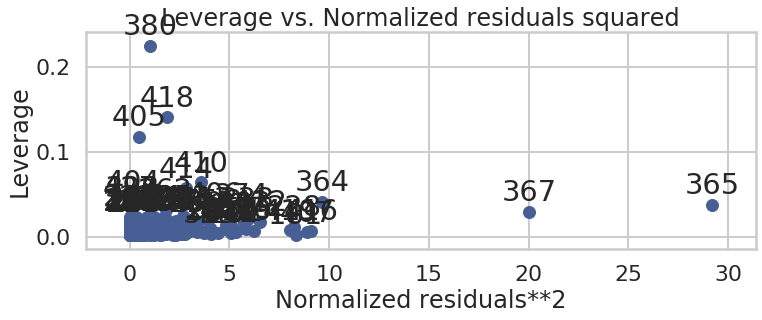

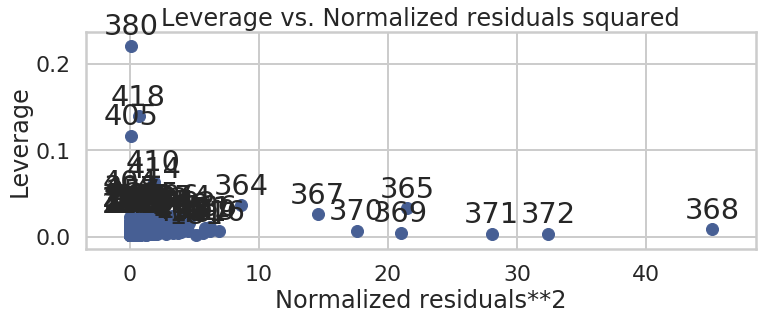

In [154]:
# get leverage plots
sm.graphics.plot_leverage_resid2(fitted_no50)
sm.graphics.plot_leverage_resid2(fitted)
plt.show()

There are still some extreme residuals, but they are not as large.

Now, I will observe the effect of removing the outliers.

In [155]:
# get rows to drop
outlier_lst = fitted.resid.sort_values(ascending=False)[:7].index.tolist()
outlier_lst

[368, 372, 371, 365, 369, 370, 367]

In [156]:
# drop outlier observations from DataFrame
bos_nooutlier = bos.drop(outlier_lst)
bos_nooutlier.head()

CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   PTRATIO       B  LSTAT  PRICE  
0     15.3  396.90   4.98   24.0  
1     17.8  396.90   9.14   21.6  
2     17.8  392.83   4.03   34.7  
3     18.7  394.63   2.94   33.4  
4     18.7  396.90   5.33   36.2

In [157]:
# instantiate the model using statsmodels
model_nooutlier = ols('PRICE ~ CRIM + RM + PTRATIO', bos_nooutlier)

In [158]:
# fit the model
fitted_nooutlier = model_nooutlier.fit()
print(fitted_nooutlier.summary())

                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.719
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                     421.5
Date:                Tue, 12 May 2020   Prob (F-statistic):          7.11e-136
Time:                        23:48:37   Log-Likelihood:                -1478.3
No. Observations:                 499   AIC:                             2965.
Df Residuals:                     495   BIC:                             2982.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -6.2283      3.291     -1.893      0.0

In [159]:
# generate the explained variance score
f'The R\u00b2 score is {fitted_nooutlier.rsquared}.'

'The R² score is 0.7186897834406216.'

The $R^2$ score has improved improved by 12.5%.

In [160]:
# generate the F-statistic
f'The F-statistic is {fitted_nooutlier.fvalue}.'

'The F-statistic is 421.5410862714691.'

The F-statistic has increased by 176 points.

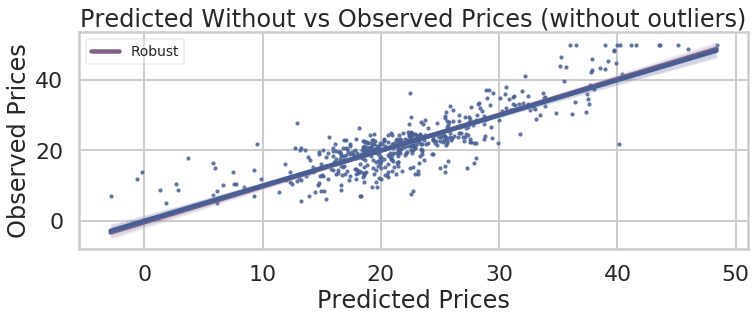

In [161]:
# plot scatterplot with regression line
figsize(12, 4)
# plot regression line weighing against outliers
sns.regplot(x=fitted_nooutlier.fittedvalues, y=bos_nooutlier.PRICE, scatter_kws={'s':10}, fit_reg = True, 
            color=rgb[colors[1]], label='Robust', robust=True, scatter=False)
# plot normal regression line
sns.regplot(x=fitted_nooutlier.fittedvalues, y=bos_nooutlier.PRICE, scatter_kws={'s':10}, fit_reg = True)

plt.xlabel('Predicted Prices')
plt.ylabel('Observed Prices')

plt.legend(loc=2, markerscale=2, fontsize='xx-small', framealpha=0.3)
plt.title('Predicted Without vs Observed Prices (without outliers)');

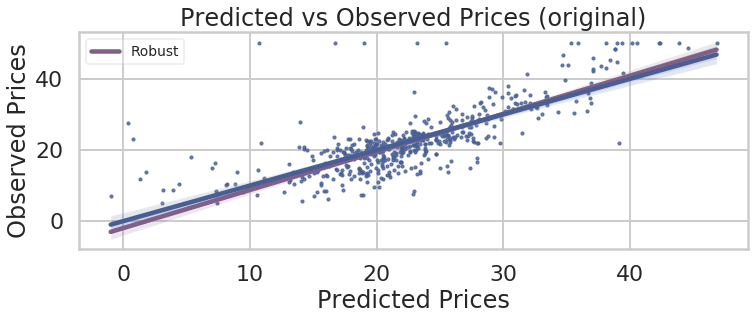

In [162]:
# plot scatterplot with regression line
figsize(12, 4)
# plot regression line weighing against outliers
sns.regplot(x=fitted.fittedvalues, y=bos.PRICE, scatter_kws={'s':10}, fit_reg = True, 
            color=rgb[colors[1]], label='Robust', robust=True, scatter=False)
# plot normal regression line
sns.regplot(x=fitted.fittedvalues, y=bos.PRICE, scatter_kws={'s':10}, fit_reg = True)

plt.xlabel('Predicted Prices')
plt.ylabel('Observed Prices')

plt.legend(loc=2, markerscale=2, fontsize='xx-small', framealpha=0.3)
plt.title('Predicted vs Observed Prices (original)');

The ceiling has been eliminated for overpriced predictions. The regression line fits over the robust line.

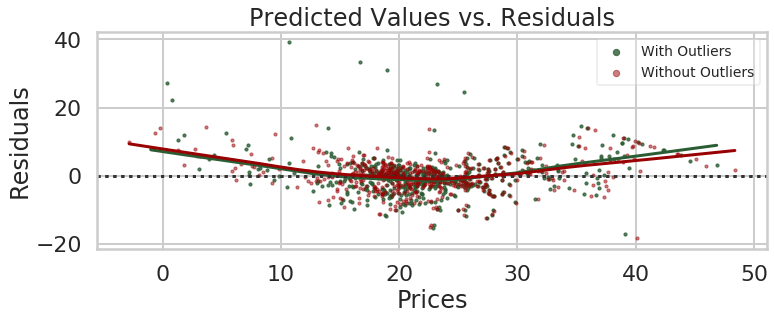

In [163]:
# look at the residuals plots
figsize(12, 4)

sns.residplot(fitted.fittedvalues, bos.PRICE, lowess=True, scatter_kws={'s':10}, 
              color=rgb[colors[4]], line_kws={'linewidth':3}, label='With Outliers')
sns.residplot(fitted_nooutlier.fittedvalues, bos_nooutlier.PRICE, lowess=True, scatter_kws={'s':10, 'alpha':0.5}, 
              color=rgb[colors[2]], line_kws={'linewidth':3}, label='Without Outliers')

plt.xlabel('Prices')
plt.ylabel('Residuals')

plt.legend(loc=1, markerscale=2, fontsize='xx-small', framealpha=0.3)
plt.title('Predicted Values vs. Residuals');

The outliers are gone, but the residuals are still unbalanced.

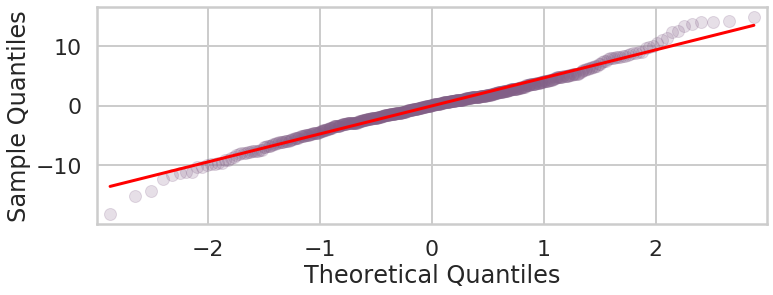

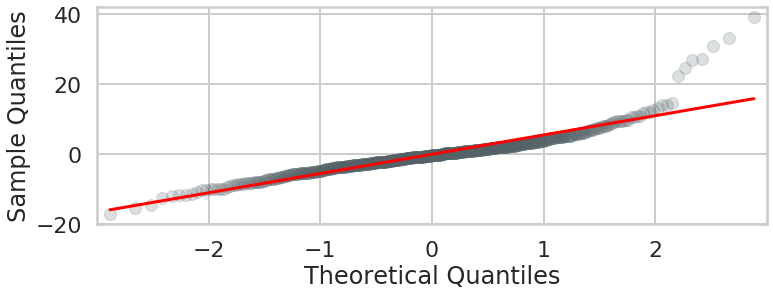

In [164]:
# get quantile-quantile plots
qqplot(fitted_nooutlier.resid, line='r', c=rgb[colors[1]], alpha=0.2)
qqplot(fitted.resid, line='r', c=rgb[colors[6]], alpha=0.2)
plt.show()

The distribution is closer to normal at the high values, but the low values are now digressing.

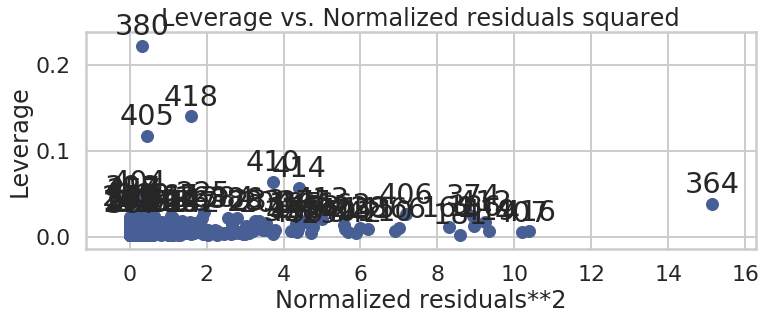

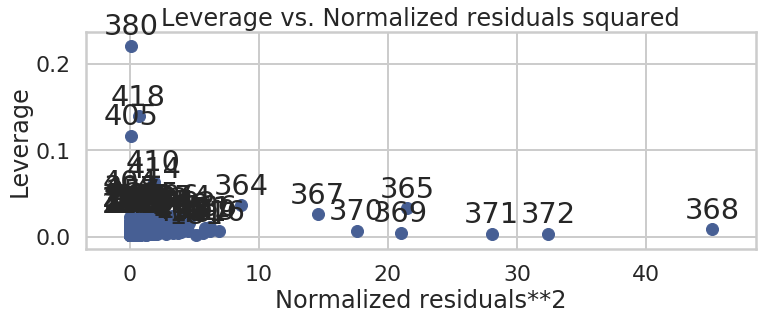

In [165]:
# get leverage plots
sm.graphics.plot_leverage_resid2(fitted_nooutlier)
sm.graphics.plot_leverage_resid2(fitted)
plt.show()

The outlier values have been removed.

Now, I will observe the effect of removing the high leverage observations.

In [166]:
# get rows to drop
crime_lst = bos.CRIM.sort_values(ascending=False)[:8].index.tolist()
crime_lst

[380, 418, 405, 410, 414, 404, 398, 427]

In [167]:
# drop high crime observations from DataFrame
bos_nocrime = bos.drop(crime_lst)
bos_nocrime.head()

CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   PTRATIO       B  LSTAT  PRICE  
0     15.3  396.90   4.98   24.0  
1     17.8  396.90   9.14   21.6  
2     17.8  392.83   4.03   34.7  
3     18.7  394.63   2.94   33.4  
4     18.7  396.90   5.33   36.2

In [168]:
# instantiate the model using statsmodels
model_nocrime = ols('PRICE ~ CRIM + RM + PTRATIO', bos_nocrime)

In [169]:
# fit the model
fitted_nocrime = model_nocrime.fit()
print(fitted_nocrime.summary())

                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.584
Method:                 Least Squares   F-statistic:                     233.2
Date:                Tue, 12 May 2020   Prob (F-statistic):           3.20e-94
Time:                        23:48:52   Log-Likelihood:                -1585.9
No. Observations:                 498   AIC:                             3180.
Df Residuals:                     494   BIC:                             3197.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.8948      4.051     -0.961      0.3

In [170]:
# generate the explained variance score
f'The R\u00b2 score is {fitted_nocrime.rsquared}.'

'The R² score is 0.5861058529889556.'

The $R^2$ score is the same.

In [171]:
# generate the F-statistic
f'The F-statistic is {fitted_nocrime.fvalue}.'

'The F-statistic is 233.18062799989124.'

The F-statistic has decreased by 12 points.

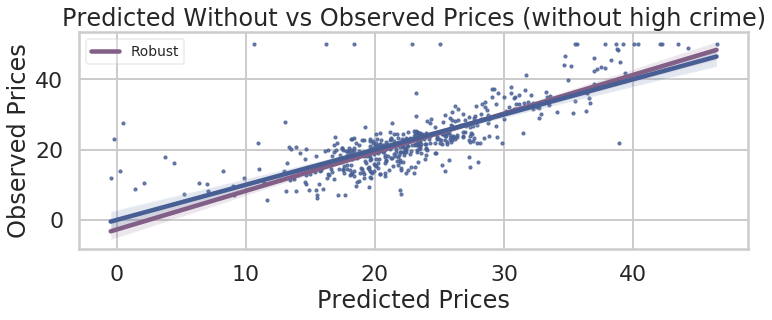

In [172]:
# plot scatterplot with regression line
figsize(12, 4)
# plot regression line weighing against outliers
sns.regplot(x=fitted_nocrime.fittedvalues, y=bos_nocrime.PRICE, scatter_kws={'s':10}, fit_reg = True, 
            color=rgb[colors[1]], label='Robust', robust=True, scatter=False)
# plot normal regression line
sns.regplot(x=fitted_nocrime.fittedvalues, y=bos_nocrime.PRICE, scatter_kws={'s':10}, fit_reg = True)

plt.xlabel('Predicted Prices')
plt.ylabel('Observed Prices')

plt.legend(loc=2, markerscale=2, fontsize='xx-small', framealpha=0.3)
plt.title('Predicted Without vs Observed Prices (without high crime)');

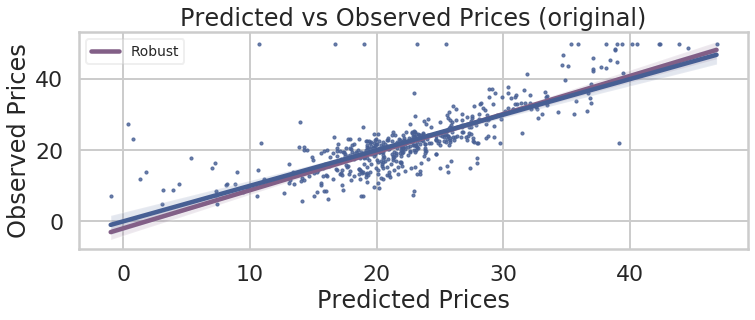

In [173]:
# plot scatterplot with regression line
figsize(12, 4)
# plot regression line weighing against outliers
sns.regplot(x=fitted.fittedvalues, y=bos.PRICE, scatter_kws={'s':10}, fit_reg = True, 
            color=rgb[colors[1]], label='Robust', robust=True, scatter=False)
# plot normal regression line
sns.regplot(x=fitted.fittedvalues, y=bos.PRICE, scatter_kws={'s':10}, fit_reg = True)

plt.xlabel('Predicted Prices')
plt.ylabel('Observed Prices')

plt.legend(loc=2, markerscale=2, fontsize='xx-small', framealpha=0.3)
plt.title('Predicted vs Observed Prices (original)');

The ceiling is still there. The regression line is worse.

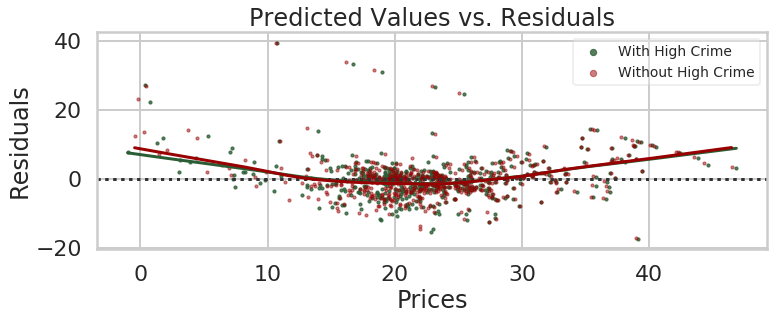

In [174]:
# look at the residuals plots
figsize(12, 4)

sns.residplot(fitted.fittedvalues, bos.PRICE, lowess=True, scatter_kws={'s':10}, 
              color=rgb[colors[4]], line_kws={'linewidth':3}, label='With High Crime')
sns.residplot(fitted_nocrime.fittedvalues, bos_nocrime.PRICE, lowess=True, scatter_kws={'s':10, 'alpha':0.5}, 
              color=rgb[colors[2]], line_kws={'linewidth':3}, label='Without High Crime')

plt.xlabel('Prices')
plt.ylabel('Residuals')

plt.legend(loc=1, markerscale=2, fontsize='xx-small', framealpha=0.3)
plt.title('Predicted Values vs. Residuals');

The outliers are still there, and the residuals are still unbalanced.

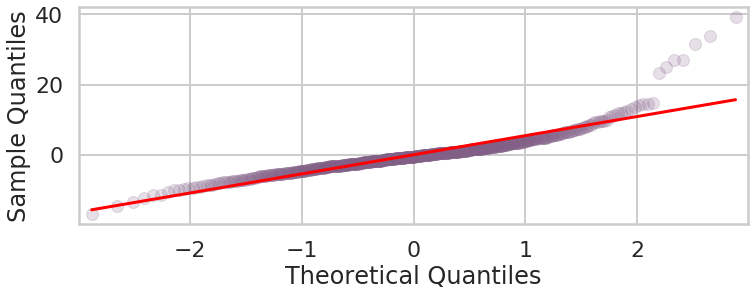

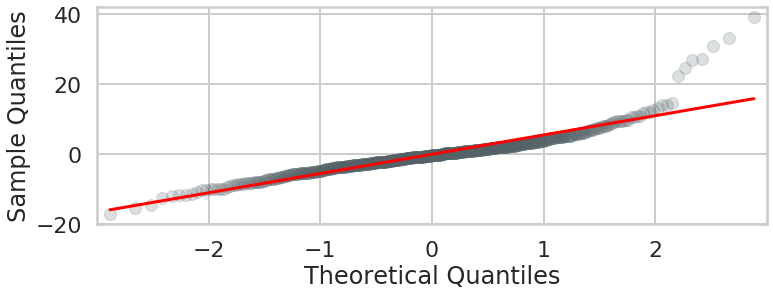

In [175]:
# get quantile-quantile plots
qqplot(fitted_nocrime.resid, line='r', c=rgb[colors[1]], alpha=0.2)
qqplot(fitted.resid, line='r', c=rgb[colors[6]], alpha=0.2)
plt.show()

The distribution has not changed.

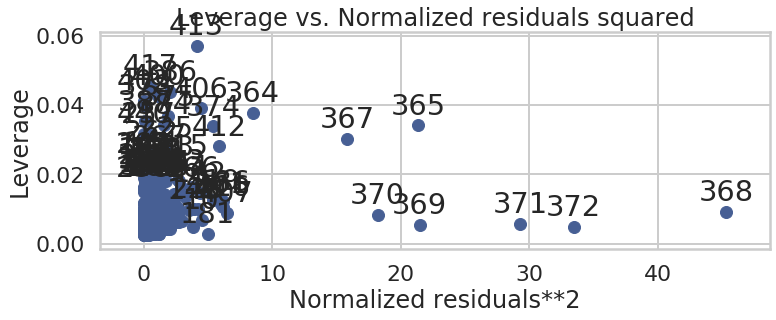

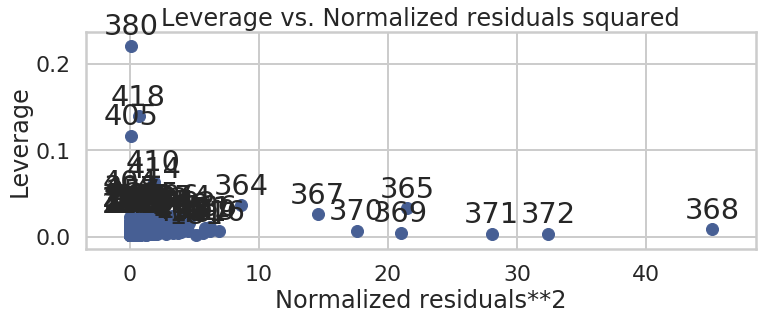

In [176]:
# get leverage plots
sm.graphics.plot_leverage_resid2(fitted_nocrime)
sm.graphics.plot_leverage_resid2(fitted)
plt.show()

The highest leverage values have been removed.<br>
There has been no improvement to the model.

Now, I will eliminate both outliers and high leverage values.

In [177]:
# get rows to drop
crime_outlier_lst = crime_lst + outlier_lst
crime_outlier_lst

[380, 418, 405, 410, 414, 404, 398, 427, 368, 372, 371, 365, 369, 370, 367]

In [178]:
# drop high crime and outlier observations from DataFrame
bos_no_co = bos.drop(crime_outlier_lst)
bos_no_co.head()

CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   PTRATIO       B  LSTAT  PRICE  
0     15.3  396.90   4.98   24.0  
1     17.8  396.90   9.14   21.6  
2     17.8  392.83   4.03   34.7  
3     18.7  394.63   2.94   33.4  
4     18.7  396.90   5.33   36.2

In [179]:
# instantiate the model using statsmodels
model_no_co = ols('PRICE ~ CRIM + RM + PTRATIO', bos_no_co)

In [180]:
# fit the model
fitted_no_co = model_no_co.fit()
print(fitted_no_co.summary())

                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.720
Model:                            OLS   Adj. R-squared:                  0.719
Method:                 Least Squares   F-statistic:                     418.2
Date:                Tue, 12 May 2020   Prob (F-statistic):          2.58e-134
Time:                        23:49:06   Log-Likelihood:                -1447.2
No. Observations:                 491   AIC:                             2902.
Df Residuals:                     487   BIC:                             2919.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -6.9533      3.260     -2.133      0.0

In [181]:
# generate the explained variance score
f'The R\u00b2 score is {fitted_no_co.rsquared}.'

'The R² score is 0.7203872775434015.'

The $R^2$ score has improved by 12.5%, just like when only the outliers were dropped.

In [182]:
# generate the F-statistic
f'The F-statistic is {fitted_no_co.fvalue}.'

'The F-statistic is 418.2315705348399.'

The F-statistic has increased by 173 points, three point less than when only the outliers were removed.

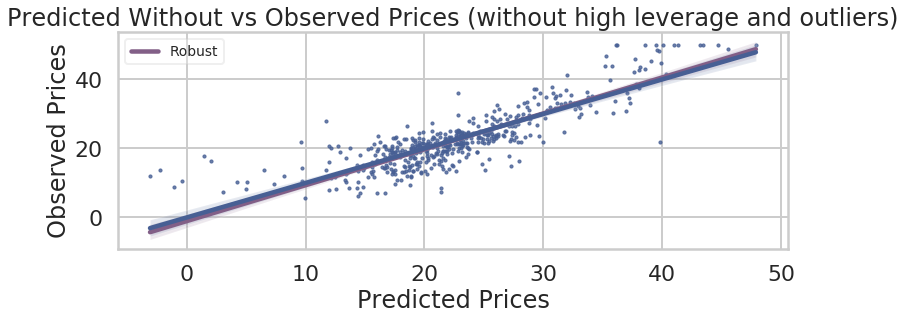

In [183]:
# plot scatterplot with regression line
figsize(12, 4)
# plot regression line weighing against outliers
sns.regplot(x=fitted_no_co.fittedvalues, y=bos_no_co.PRICE, scatter_kws={'s':10}, fit_reg = True, 
            color=rgb[colors[1]], label='Robust', robust=True, scatter=False)
# plot normal regression line
sns.regplot(x=fitted_no_co.fittedvalues, y=bos_no_co.PRICE, scatter_kws={'s':10}, fit_reg = True)

plt.xlabel('Predicted Prices')
plt.ylabel('Observed Prices')

plt.legend(loc=2, markerscale=2, fontsize='xx-small', framealpha=0.3)
plt.title('Predicted Without vs Observed Prices (without high leverage and outliers)');

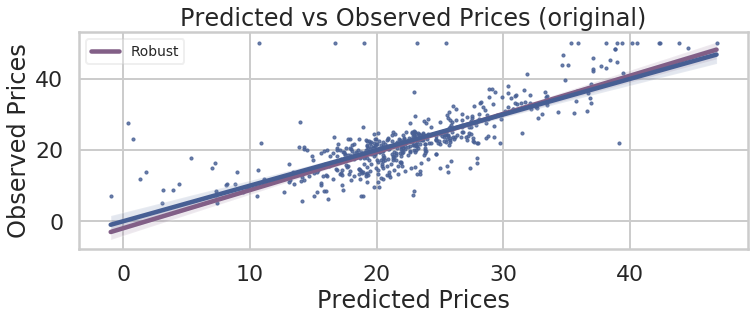

In [184]:
# plot scatterplot with regression line
figsize(12, 4)
# plot regression line weighing against outliers
sns.regplot(x=fitted.fittedvalues, y=bos.PRICE, scatter_kws={'s':10}, fit_reg = True, 
            color=rgb[colors[1]], label='Robust', robust=True, scatter=False)
# plot normal regression line
sns.regplot(x=fitted.fittedvalues, y=bos.PRICE, scatter_kws={'s':10}, fit_reg = True)

plt.xlabel('Predicted Prices')
plt.ylabel('Observed Prices')

plt.legend(loc=2, markerscale=2, fontsize='xx-small', framealpha=0.3)
plt.title('Predicted vs Observed Prices (original)');

The ceiling has been eliminated for overpriced predictions. The regression line fits over the robust line.

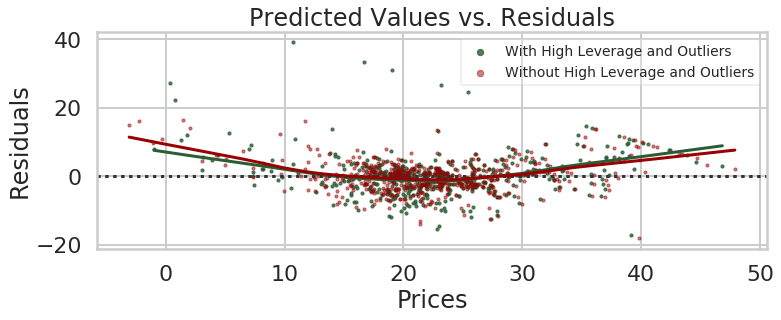

In [185]:
# look at the residuals plots
figsize(12, 4)

sns.residplot(fitted.fittedvalues, bos.PRICE, lowess=True, scatter_kws={'s':10}, 
              color=rgb[colors[4]], line_kws={'linewidth':3}, label='With High Leverage and Outliers')
sns.residplot(fitted_no_co.fittedvalues, bos_no_co.PRICE, lowess=True, scatter_kws={'s':10, 'alpha':0.5}, 
              color=rgb[colors[2]], line_kws={'linewidth':3}, label='Without High Leverage and Outliers')

plt.xlabel('Prices')
plt.ylabel('Residuals')

plt.legend(loc=1, markerscale=2, fontsize='xx-small', framealpha=0.3)
plt.title('Predicted Values vs. Residuals');

The outliers are gone, but the residuals are still unbalanced.

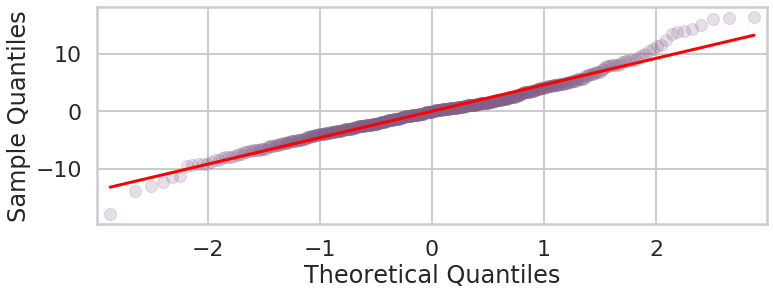

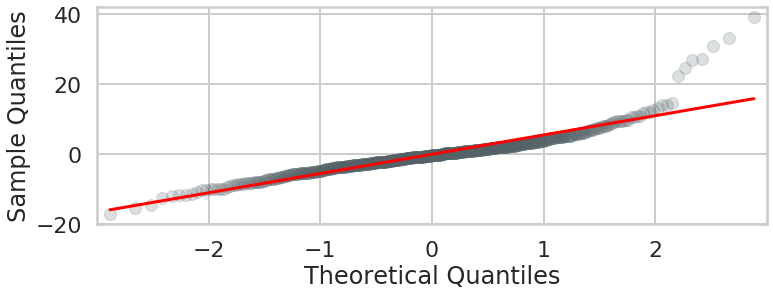

In [186]:
# get quantile-quantile plots
qqplot(fitted_no_co.resid, line='r', c=rgb[colors[1]], alpha=0.2)
qqplot(fitted.resid, line='r', c=rgb[colors[6]], alpha=0.2)
plt.show()

The distribution is closer to normal at the high values, but the low values are now digressing.

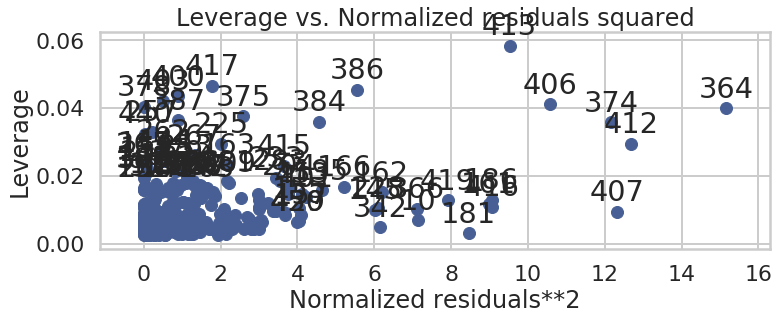

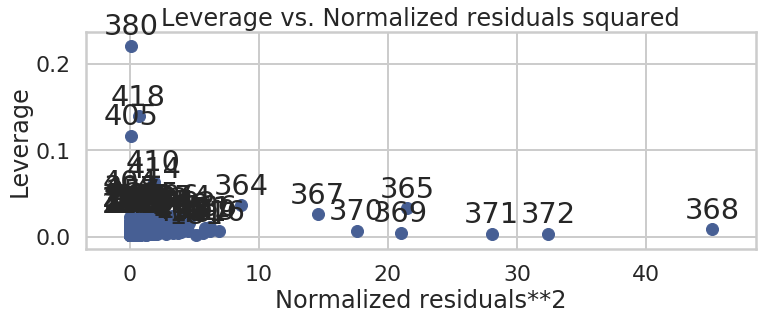

In [187]:
# get leverage plots
sm.graphics.plot_leverage_resid2(fitted_no_co)
sm.graphics.plot_leverage_resid2(fitted)
plt.show()

The outlier and high leverage values have been removed.<br>
The points are now better distributed.

Now I will fit the model without the ceiling and outlier values.

In [188]:
# get rows to drop
no50_outlier_lst = no50_lst + outlier_lst
no50_outlier_lst[:5]

[161, 162, 163, 166, 186]

In [189]:
# drop ceiling and outlier observations from DataFrame
bos_no_50o = bos.drop(no50_outlier_lst)
bos_no_50o.head()

CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   PTRATIO       B  LSTAT  PRICE  
0     15.3  396.90   4.98   24.0  
1     17.8  396.90   9.14   21.6  
2     17.8  392.83   4.03   34.7  
3     18.7  394.63   2.94   33.4  
4     18.7  396.90   5.33   36.2

In [190]:
# instantiate the model using statsmodels
model_no_50o = ols('PRICE ~ CRIM + RM + PTRATIO', bos_no_50o)

In [191]:
# fit the model
fitted_no_50o = model_no_50o.fit()
print(fitted_no_50o.summary())

                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.675
Model:                            OLS   Adj. R-squared:                  0.673
Method:                 Least Squares   F-statistic:                     335.5
Date:                Tue, 12 May 2020   Prob (F-statistic):          8.75e-118
Time:                        23:49:21   Log-Likelihood:                -1424.7
No. Observations:                 488   AIC:                             2857.
Df Residuals:                     484   BIC:                             2874.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.3587      3.201     -1.049      0.2

In [192]:
# generate the explained variance score
f'The R\u00b2 score is {fitted_no_50o.rsquared}.'

'The R² score is 0.6752908136384024.'

The $R^2$ score has improved by 8%, which is 4.5% less than when only the outliers were dropped.

In [193]:
# generate the F-statistic
f'The F-statistic is {fitted_no_50o.fvalue}.'

'The F-statistic is 335.5215143569683.'

The F-statistic has increased by 90 points, 86 points less than when only removing the outliers.

Removing the high leverage values showed no improvement to the model.

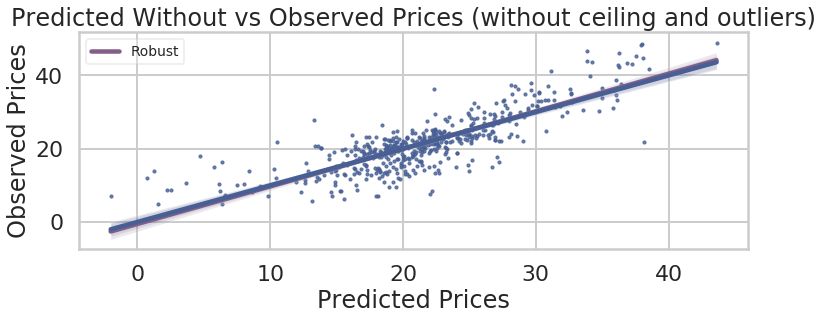

In [194]:
# plot scatterplot with regression line
figsize(12, 4)
# plot regression line weighing against outliers
sns.regplot(x=fitted_no_50o.fittedvalues, y=bos_no_50o.PRICE, scatter_kws={'s':10}, fit_reg = True, 
            color=rgb[colors[1]], label='Robust', robust=True, scatter=False)
# plot normal regression line
sns.regplot(x=fitted_no_50o.fittedvalues, y=bos_no_50o.PRICE, scatter_kws={'s':10}, fit_reg = True)

plt.xlabel('Predicted Prices')
plt.ylabel('Observed Prices')

plt.legend(loc=2, markerscale=2, fontsize='xx-small', framealpha=0.3)
plt.title('Predicted Without vs Observed Prices (without ceiling and outliers)');

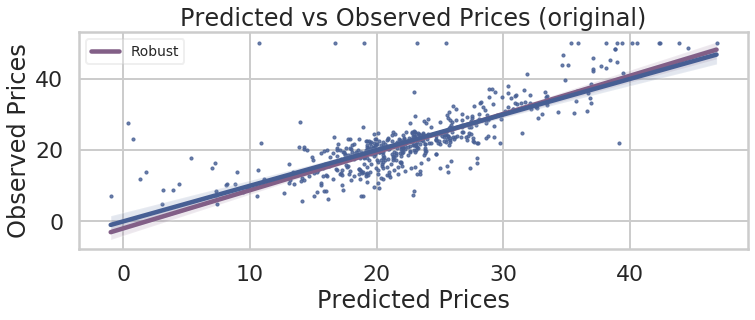

In [195]:
# plot scatterplot with regression line
figsize(12, 4)
# plot regression line weighing against outliers
sns.regplot(x=fitted.fittedvalues, y=bos.PRICE, scatter_kws={'s':10}, fit_reg = True, 
            color=rgb[colors[1]], label='Robust', robust=True, scatter=False)
# plot normal regression line
sns.regplot(x=fitted.fittedvalues, y=bos.PRICE, scatter_kws={'s':10}, fit_reg = True)

plt.xlabel('Predicted Prices')
plt.ylabel('Observed Prices')

plt.legend(loc=2, markerscale=2, fontsize='xx-small', framealpha=0.3)
plt.title('Predicted vs Observed Prices (original)');

The ceiling has been eliminated for overpriced predictions. The regression line fits over the robust line.

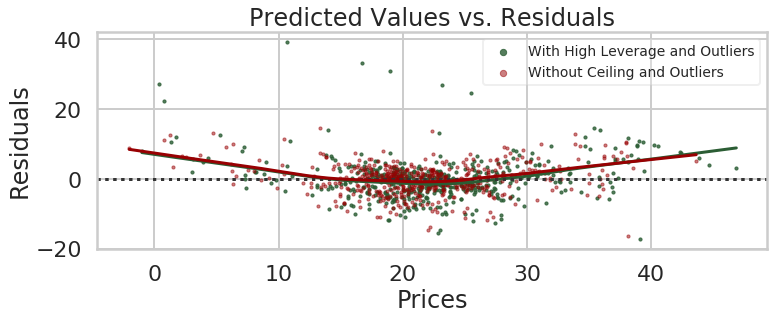

In [196]:
# look at the residuals plots
figsize(12, 4)

sns.residplot(fitted.fittedvalues, bos.PRICE, lowess=True, scatter_kws={'s':10}, 
              color=rgb[colors[4]], line_kws={'linewidth':3}, label='With High Leverage and Outliers')
sns.residplot(fitted_no_50o.fittedvalues, bos_no_50o.PRICE, lowess=True, scatter_kws={'s':10, 'alpha':0.5}, 
              color=rgb[colors[2]], line_kws={'linewidth':3}, label='Without Ceiling and Outliers')

plt.xlabel('Prices')
plt.ylabel('Residuals')

plt.legend(loc=1, markerscale=2, fontsize='xx-small', framealpha=0.3)
plt.title('Predicted Values vs. Residuals');

The outliers are gone, but the residuals are still unbalanced.

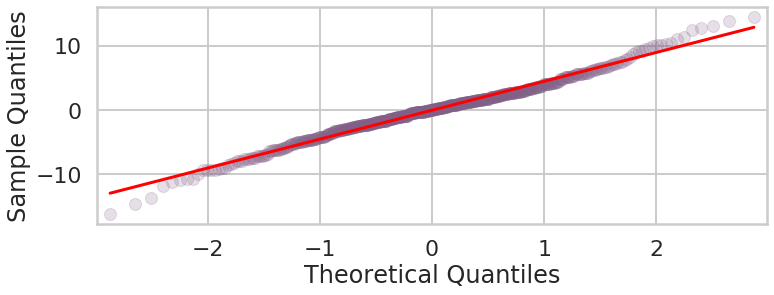

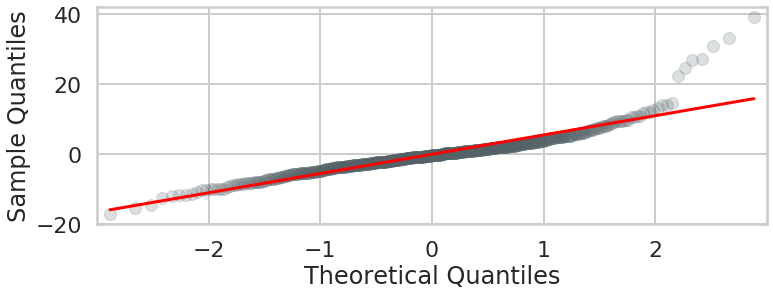

In [197]:
# get quantile-quantile plots
qqplot(fitted_no_50o.resid, line='r', c=rgb[colors[1]], alpha=0.2)
qqplot(fitted.resid, line='r', c=rgb[colors[6]], alpha=0.2)
plt.show()

The distribution is closer to normal at the high values, but the low values are now digressing.

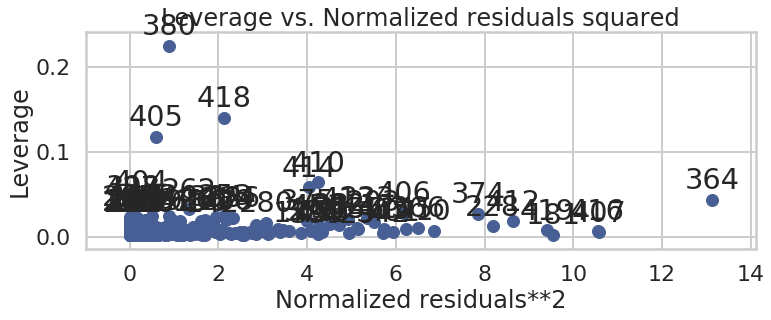

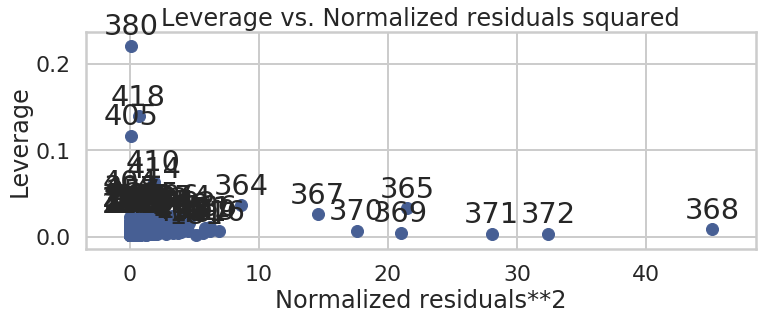

In [198]:
# get leverage plots
sm.graphics.plot_leverage_resid2(fitted_no_50o)
sm.graphics.plot_leverage_resid2(fitted)
plt.show()

The outliers have been removed.<br>

In [199]:
# create model comparision DataFrame
idx_lst = ['$r^2$ score', 'F-statistic']
col_lst = ['no leverage/outlier', 'no outlier', 'no ceiling/outlier', 'no ceiling', 'control', 'no leverage']
r2_lst = [fitted_no_co.rsquared, fitted_nooutlier.rsquared, fitted_no_50o.rsquared, 
         fitted_no50.rsquared, fitted.rsquared, fitted_nocrime.rsquared]
f_lst = [fitted_no_co.fvalue, fitted_nooutlier.fvalue, fitted_no_50o.fvalue, 
         fitted_no50.fvalue, fitted.fvalue, fitted_nocrime.fvalue]
comparison_df = pd.DataFrame([r2_lst, f_lst], index=idx_lst, columns=col_lst)
comparison_df

no leverage/outlier  no outlier  no ceiling/outlier  no ceiling  \
$r^2$ score             0.720387    0.718690            0.675291    0.636598   
F-statistic           418.231571  421.541086          335.521514  283.787591   

                control  no leverage  
$r^2$ score    0.594341     0.586106  
F-statistic  245.164490   233.180628

From the comparision DataFrame, it can be observed that the best fitting models can be found by at least removing the outliers.<br>
Removing the high leverage values as well does not result in a noticeably better fit.<br>
Removing the ceiling values gives a better fit than the model with the full number of observations, but reduces the benefits of removing the outliers.<br>
Removing the high leverage values alone give a worse fitting model compared to the full model.<br>
This reinforces what was observed from the analysis of the Cook's distances.<br>
Even though none of the observations had a significant Cook's distance, the outliers were significantly influencial on their own.

All of the F-statistics strongly suggest that at least some of the coefficients are non-zero.<br>
The model with only the outliers removed suggest this the most.

The model with the outliers removed is the one that I would choose to perform predictions on this dataset.